In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from lib.analysis.cell_roi import RandomROISample
from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.false_discovery_control import false_discovery_control
from lib.analysis.trace_metrics import TraceMetrics

###########################################
# Now we allow 3 barrels in a field of view to be analyzed
# in catalog, number of barrels is saved in Num_Barrels column
# The <slic>_<loc>_barrel_boundary.dat file is in ascending order of barrels, one
#   separate ROI for each barrel
###########################################

In [2]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
slice_type =  'sagittal' # 'merged' #'coronal' # 
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"

if slice_type != 'merged':
    if slice_type == 'coronal':
        data_dir += "coronal-crossing/"
    else:
        data_dir += (slice_type + "/")

camera_program = 4
um_per_px = 6.0

# annotation settings
skip_draw_annotations = True  # If True, don't draw any new annotations

# Movie maker settings
enable_photoZ_interact = False
initialize_photoZ = False

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [4]:
def get_stim_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_electrode.dat"

def get_barrel_boundary_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_barrel_boundary.dat"

def get_L4_L5_boundary_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_L5_boundary.dat"

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

crossing_directions = ["Lateral", "Medial"]
if slice_type == 'sagittal':
    crossing_directions = ["Rostral", "Caudal"]

stim_df = {
    'Date': [],
    "Slice_Loc": [],
    'stim_distance1': [], # distance to L4-L5 boundary
    'stim_distance2': [] # distance to neighboring barrel (in final CSV, this is 0 if home barrel)
}
already_drawn_slic_loc = {}

In [5]:
# First ask user to annotate some images with:
#       - Electrode loc 
#       - L4 - L5 boundary
#       - Barrel boundary that is being crossed
# Calculate:
#       - Distance from electrode to L4 boundary (distance1)
#       - Distance from electrode to neighboring barrel (distance2)
# This will be used to calculate distance from electrode to L4 boundary and from electrode to neighboring barrel

def parse_date(subdir):
    try:
        char_select = -len('dd-mm-yyyy')
        subdir = subdir.replace("\\", "/")
        date = subdir.split("/")[-1][char_select:]
        date = [int(x) for x in date.split("-")]
        date = "/".join([str(d) for d in date])
        return date
    except Exception as e:
        print(e, "could not process date.")
        return subdir

data_map = {}
for subdir, dirs, files in os.walk(data_dir):

    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = parse_date(subdir)

        # take selected zda and expand into separate subdir for each zda file
        print(os.listdir(selected_zda_dir))
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                print("\n", selected_zda_dir + "/" + zda_file)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]

                if subdir not in data_map:
                    data_map[subdir] = {}
                if slic_id not in data_map[subdir]:
                    data_map[subdir][slic_id] = {}
                if loc_id not in data_map[subdir][slic_id]:
                    data_map[subdir][slic_id][loc_id] = {
                        'zda_files': []
                    }
                data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)

                annotate_id = date + "_" + str(slic_id) + "_" + str(loc_id)
                if skip_draw_annotations:
                    continue
                if annotate_id in already_drawn_slic_loc and already_drawn_slic_loc[annotate_id]:
                    print("Already annotated ", annotate_id, ", skipping.")
                    continue
                already_drawn_slic_loc[annotate_id] = True

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id)

                img_aligner = ImageAlign()

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor

                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)
                        orig_arr_shape = dic_electrode.shape

                        # ask user to select site of stim and layer/barrel borders
                        #       - Distance from electrode to L4 boundary (distance1)
                        #       - Distance from electrode to neighboring barrel (distance2)
                        if not skip_draw_annotations:
                            window_title = date + " " + rec_id

                            # ask user to select electrode
                            dic_electrode, electrode_coords = img_aligner.draw_electrode_on_image(
                                dic_electrode, 
                                window_title + " Electrode")
                            dic_electrode = np.array(dic_electrode)

                            # mark the electrode location into fluor image
                            x_el, y_el = electrode_coords['electrode']
                            for dx in range(-5, 5):
                                for dy in range(-5, 5):
                                    if x_el + dx >= 0 and x_el + dx < fluor.shape[1] and y_el + dy >= 0 and y_el + dy < fluor.shape[0]:
                                        fluor[int(y_el) + dy, int(x_el) + dx] = 0

                            # ask user to select L4 - L5 boundary
                            distance1_boundary, distance1_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance1 Boundary (L4 - L5 boundary)")
                            distance1_boundary = np.array(distance1_boundary)

                            # ask user to select barrel boundary
                            distance2_boundary, distance2_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance2 Boundary (Barrel boundary)")
                            distance2_boundary = np.array(distance2_boundary)
                            
                            # make 1 row of 2 subplots
                            fig, axes = plt.subplots(1, 3)
                            axes[0].imshow(dic_electrode, cmap='gray')
                            axes[1].imshow(fluor, cmap='gray')
                            
                            x_d1, y_d1 = distance1_coords['electrode']
                            x_d2, y_d2 = distance2_coords['electrode']

                            for ax in axes[:2]:
                                l1, = ax.plot(x_el, y_el, marker="*", color='red', label="Electrode")
                                l2, = ax.plot(x_d1, y_d1, marker="*", color='green', label="L4 - L5 boundary")
                                l3, = ax.plot(x_d2, y_d2, marker="*", color='blue', label="Barrel boundary")
                                ax.set_yticks([])
                                ax.set_xticks([])


                            axes[2].legend(handles=[l1, l2, l3],
                                           labels=["Electrode", "L4 - L5 boundary", "Barrel boundary"])
                            axes[2].axis('off')
                            plt.show()

                            # no need to transform the coordinates, just calculate distances and convert px -> microns
                            dic_um_per_px = 425 / fluor.shape[1]
                            distance1 = Line([x_el, y_el], [x_d1, y_d1]).get_length() * dic_um_per_px
                            distance2 = Line([x_el, y_el], [x_d2, y_d2]).get_length() * dic_um_per_px
                            print("Distance1 (L4 - L5 boundary):", distance1)
                            print("Distance2 (Barrel boundary):", distance2)

                            # append data to Dataframe to write to CSV

                            # turn date into 4-digit year
                            if len(date.split("/")[-1]) < len("20YY"):
                                date = "/".join(date.split("/")[:2] + ["20" + date.split("/")[-1]])
                            
                            stim_df["Date"].append(date)
                            stim_df["Slice_Loc"].append(str(slic) + "_" + str(loc))
                            stim_df["stim_distance1"].append(distance1)
                            stim_df["stim_distance2"].append(distance2)
                            
                            
stim_df = pd.DataFrame(stim_df)



 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24
['01_01_01.zda', '01_01_02.zda', '01_02_01.zda', '01_02_02.zda', '02_01_01.zda', '02_02_01.zda', '02_02_02.zda', '03_01_01.zda', '03_01_02.zda', '03_02_01.zda', '03_02_02.zda', '04_01_01.zda', '04_02_01.zda', '05_01_01.zda', '05_02_01.zda', '1_1_barrel_boundary.dat', '1_1_electrode.dat', '1_1_L5_boundary.dat', '1_2_barrel_boundary.dat', '1_2_electrode.dat', '1_2_L5_boundary.dat', '1_barrel_rois.dat', '1_barrel_roisROIs-rand_0.dat', '1_barrel_roisROIs-rand_1.dat', '1_barrel_roisROIs-stripe_0.dat', '1_barrel_roisROIs-stripe_1.dat', '2_1_barrel_boundary.dat', '2_1_electrode.dat', '2_1_L5_boundary.dat', '2_2_barrel_boundary.dat', '2_2_electrode.dat', '2_2_L5_boundary.dat', '2_barrel_rois.dat', '2_barrel_roisROIs-rand_0.dat', '2_barrel_roisROIs-rand_1.dat', '2_barrel_roisROIs-stripe_0.dat', '2_barrel_roisROIs-stripe_1.dat', '3_1_barrel_boundary.dat', '3_1_electrode.dat', '3_1_L5_boundary.dat', '3_2_barrel_boundary.da

In [6]:
if skip_draw_annotations:
    # load from CSV
    stim_df = pd.read_csv(data_dir + slice_type + "_crossing_with_distances.csv")
else:
    # write df to CSV
    stim_df.to_csv(data_dir + slice_type + "_crossing_with_distances.csv", index=False)
stim_df

,Date,Slice_Loc,stim_distance1,stim_distance2
0,5/29/2024,2_1,60.813524,82.793827
1,5/29/2024,2_2,121.039039,52.296078
2,5/29/2024,2_3,121.041936,145.522129
3,5/29/2024,4_1,120.001227,78.297929
4,5/29/2024,4_2,154.832646,103.624931
5,5/29/2024,5_1,191.644902,108.093227
6,5/29/2024,5_2,166.888653,73.996707
7,5/31/2024,1_1,112.271697,144.845388
8,5/31/2024,1_2,161.770051,115.913966
9,5/31/2024,2_1,167.660973,117.152856


In [7]:
# go through the ZDA files and extract amp arrays 
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id):
    return subdir + "/" + "ampArray_" + slic_loc_id + ".dat"

for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    aPhz = AutoPhotoZ(data_dir=subdir)
    if enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                amp_array_filename = get_amp_array_filename(subdir, slic_loc_id)
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                    aPhz.save_background(filename=amp_array_filename)

                if 'amp_arrays' not in data_map[subdir][slic_id][loc_id]:
                    data_map[subdir][slic_id][loc_id]['amp_arrays'] = []
                    data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + str(slic_id) + "_barrel_rois.dat"

                data_map[subdir][slic_id][loc_id]['amp_arrays'].append(amp_array_filename)
                data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + str(slic_id) + "_barrel_rois.dat"


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_02_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//02_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//02_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//02_02_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//03_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//03_02_01.zda


In [8]:
# use read_dat_arr_file to read in the amp arrays
# also read in the barrel ROIs (#_barrel_rois.dat) to know which pixels' amplitudes to analyze
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

final_df = {
    "Date": [],
    "Slice_Loc": [],
    "Neighbor_Barrel": [], 
    "Stim_Location": [],
    "Home_Barrel": [],
    "Home_Barrel_Amp": [],
    "Neighbor_Barrel_Amp": [],
    "Neighbor_Responding_Area_Fraction": [],
    'stim_distance1': [],
    'stim_distance2': [],
    'Age':[],
    'Sex':[],
    'crossing_direction': [] # to caudal or to rostral
}
if slice_type == 'sagittal':
    final_df["Most_Caudal_Barrel"] = []
elif slice_type == 'coronal':
    final_df["Most_Medial_Barrel"] = []

# load catalog of metadata
catalog_df = pd.read_csv(data_dir + slice_type + "_catalog.csv")
show_plots = False

for subdir in data_map:
    date = parse_date(subdir)
    
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file']
            roi_list = rfr = ROIFileReader(roi_file).get_roi_list()  # list of ROIs as diode numbers

            for amp_arr_file in data_map[subdir][slic_id][loc_id]['amp_arrays']:
                print(amp_arr_file)

                amp_array = read_dat_arr_file(amp_arr_file)


                # get amp cutoff for this slice/loc from catalog_df
                slice_loc_id = str(slic_id) + "_" + str(loc_id)

                # convert mm/dd/yy to mm/dd/yyyy
                if len(date.split("/")[-1]) < len("yyyy"):
                    date = date.split("/")
                    date = date[0] + "/" + date[1] + "/20" + date[2]
                print(date, slice_loc_id)

                masked_amp_array = np.zeros(amp_array.shape)

                # convert diode to xy
                rois = [LaminarROI(roi).get_points() for roi in roi_list]

                slice_loc_df = catalog_df[(catalog_df['Slice_Loc'] == slice_loc_id) & 
                                          (catalog_df['Date'] == date)]

                # get home barrel index (1-indexed)
                home_barrel = slice_loc_df['Home_Barrel'].values[0]

                # calculate crossing direction
                if slice_type == 'sagittal':
                    most_medial_barrel = slice_loc_df['Most_Caudal_Barrel'].values[0]
                elif slice_type == 'coronal':
                    most_medial_barrel = slice_loc_df['Most_Medial_Barrel'].values[0]
                num_barrels = 2
                crossing_directions
                try:
                    num_barrels = slice_loc_df['Num_Barrels'].values[0]
                except:
                    pass
                for neighbor_barrel in range(1, num_barrels + 1):
                    if neighbor_barrel == home_barrel:
                        continue
                    crossing_direction = None
                    if num_barrels == 2:
                        if home_barrel == most_medial_barrel:
                            crossing_direction = crossing_directions[0]
                        else:
                            crossing_direction = crossing_directions[1]
                    elif num_barrels == 3:
                        # most medial barrel can only be 1 or 3, not 2
                        if most_medial_barrel == 1:
                            if home_barrel == 1:
                                crossing_direction = crossing_directions[0]
                            elif home_barrel == 3:
                                crossing_direction = crossing_directions[1]
                            elif home_barrel == 2:
                                # Then there may be measurements for neighbors in both medial and lateral directions
                                if neighbor_barrel == 1:
                                    crossing_direction = crossing_directions[1]
                                elif neighbor_barrel == 3:
                                    crossing_direction = crossing_directions[0]
                        if most_medial_barrel == 3:
                            if home_barrel == 3:
                                crossing_direction = crossing_directions[0]
                            elif home_barrel == 1:
                                crossing_direction = crossing_directions[1]
                            elif home_barrel == 2:
                                # Then there may be measurements for neighbors in both medial and lateral directions
                                if neighbor_barrel == 3:
                                    crossing_direction = crossing_directions[1]
                                elif neighbor_barrel == 1:
                                    crossing_direction = crossing_directions[0]
                        

                    # get average amplitude of home barrel
                    home_barrel_roi = rois[int(home_barrel) - 1]
                    home_barrel_amp = np.mean([amp_array[y, x] for x, y in home_barrel_roi])

                    # get average amplitude of neighboring barrel
                    neighbor_barrel_roi = rois[neighbor_barrel - 1]
                    neighbor_barrel_amp = np.mean([amp_array[y, x] for x, y in neighbor_barrel_roi])

                    amp_cutoff = home_barrel_amp * 0.35

                    # mask out everything except the ROIs
                    for roi in rois:
                        for x, y in roi:
                            if amp_array[y, x] > amp_cutoff:
                                masked_amp_array[y, x] = amp_array[y, x]
                    
                    # display amp array
                    if show_plots:
                        plt.imshow(masked_amp_array, cmap='hot')
                        plt.title(date + " " + slice_loc_id + " Amp cutoff: " + str(amp_cutoff)[:4])
                        plt.show()

                    # calculate barrel ROI responding area fraction of neighbor barrel
                    resp_area = 0
                    for x, y in neighbor_barrel_roi:
                        if masked_amp_array[y, x] > amp_cutoff:
                            resp_area += 1
                    resp_area = resp_area / len(neighbor_barrel_roi)

                    # get stim distances from stim_df
                    slice_loc_stim_df = stim_df[(stim_df['Date'] == date) &
                                                (stim_df['Slice_Loc'] == slice_loc_id)]

                    # append to final_df
                    final_df["Date"].append(date)
                    final_df["Slice_Loc"].append(slice_loc_id)
                    if slice_type == 'sagittal':
                        final_df["Most_Caudal_Barrel"].append(most_medial_barrel)
                    elif slice_type == 'coronal':    
                        final_df["Most_Medial_Barrel"].append(most_medial_barrel)
                    final_df["Stim_Location"].append(slice_loc_df['Stim_Location'].values[0])
                    final_df['Age'].append(slice_loc_df['Age'].values[0])
                    final_df['Sex'].append(slice_loc_df['Sex'].values[0])
                    final_df["Home_Barrel"].append(home_barrel)
                    final_df["Neighbor_Barrel"].append(neighbor_barrel)
                    final_df["Home_Barrel_Amp"].append(home_barrel_amp)
                    final_df["Neighbor_Barrel_Amp"].append(neighbor_barrel_amp)
                    final_df["Neighbor_Responding_Area_Fraction"].append(resp_area)
                    final_df['stim_distance1'].append(slice_loc_stim_df['stim_distance1'].values[0])
                    final_df['stim_distance2'].append(slice_loc_stim_df['stim_distance2'].values[0])
                    final_df['crossing_direction'].append(crossing_direction)

# create final_df Dataframe
final_df = pd.DataFrame(final_df)
final_df

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_1_1.dat
5/31/2024 1_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_1_1.dat
5/31/2024 1_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_1_2.dat
5/31/2024 1_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_1_2.dat
5/31/2024 1_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_2_1.dat
5/31/2024 2_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_2_2.dat
5/31/2024 2_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_2_2.dat
5/31/2024 2_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_3_1.dat
5/31/2024 3_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_3_1.dat
5/31/2024 3_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/

,Date,Slice_Loc,Neighbor_Barrel,Stim_Location,Home_Barrel,Home_Barrel_Amp,Neighbor_Barrel_Amp,Neighbor_Responding_Area_Fraction,stim_distance1,stim_distance2,Age,Sex,crossing_direction,Most_Caudal_Barrel
0,5/31/2024,1_1,1,L2/3,2.0,6.928083,3.090578,0.759434,112.271697,144.845388,151.0,M,Rostral,2.0
1,5/31/2024,1_1,1,L2/3,2.0,6.928083,3.090578,0.759434,112.271697,144.845388,151.0,M,Rostral,2.0
2,5/31/2024,1_2,2,L2/3,1.0,5.892812,3.880088,0.989446,161.770051,115.913966,151.0,M,Caudal,2.0
3,5/31/2024,1_2,2,L2/3,1.0,5.892812,3.880088,0.989446,161.770051,115.913966,151.0,M,Caudal,2.0
4,5/31/2024,2_1,2,L2/3,1.0,2.592887,0.595209,0.005063,167.660973,117.152856,151.0,M,Caudal,2.0
5,5/31/2024,2_2,1,L2/3,2.0,2.187771,0.889556,0.628801,162.321414,165.149424,151.0,M,Rostral,2.0
6,5/31/2024,2_2,1,L2/3,2.0,2.187771,0.889556,0.628801,162.321414,165.149424,151.0,M,Rostral,2.0
7,5/31/2024,3_1,1,L2/3,2.0,1.150381,0.370876,0.351139,158.696242,95.349379,151.0,M,Caudal,1.0
8,5/31/2024,3_1,1,L2/3,2.0,1.150381,0.370876,0.351139,158.696242,95.349379,151.0,M,Caudal,1.0
9,5/31/2024,3_2,2,L4,1.0,1.074268,1.037970,1.000000,126.914097,114.390479,151.0,M,Rostral,1.0


In [9]:
# save to CSV
final_df.to_csv(data_dir + slice_type + "_crossing_final.csv", index=False)

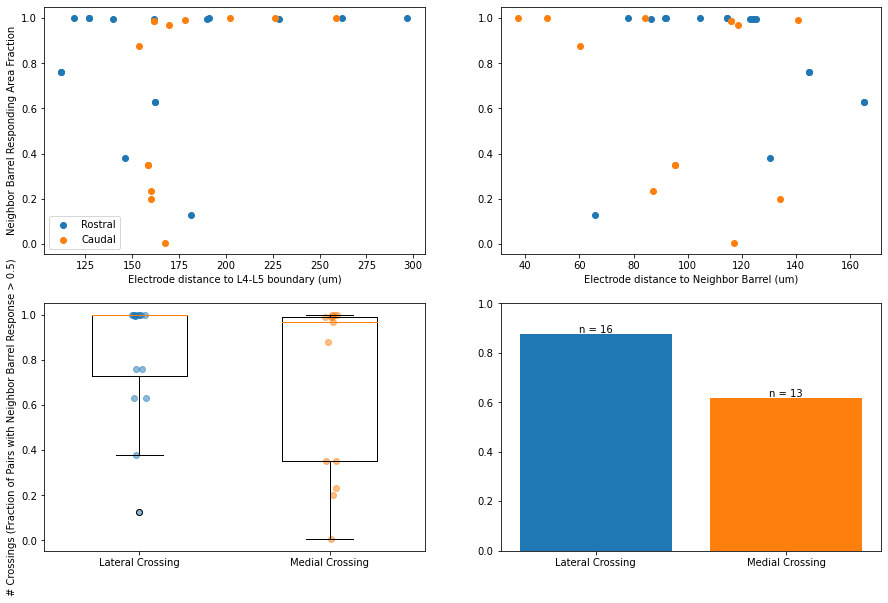

In [10]:
# plot distributions of responding area fraction for each crossing direction as scatter plots

# scatter plot of responding area fraction vs distance to L4-L5 boundary
# and vs distance to barrel boundary

handles = []
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for direction in crossing_directions:
    df = final_df[final_df['crossing_direction'] == direction]
    l1 = ax[0][0].scatter(df['stim_distance1'], df['Neighbor_Responding_Area_Fraction'], label=direction + " Crossing")
    l2 = ax[0][1].scatter(df['stim_distance2'], df['Neighbor_Responding_Area_Fraction'], label=direction + " Crossing")
    handles .append(l1)

ax[0][0].set_ylabel("Neighbor Barrel Responding Area Fraction")
ax[0][0].set_xlabel("Electrode distance to L4-L5 boundary (um)")
ax[0][1].set_xlabel("Electrode distance to Neighbor Barrel (um)")
ax[0][0].legend(handles, crossing_directions)

# in ax[1][0], plot responding area fraction distribution for each crossing direction
for i, direction in enumerate(crossing_directions):
    df = final_df[final_df['crossing_direction'] == direction]
    if len(df) == 0:
        continue
    x_jitter = [i + random.uniform(-0.04, 0.04) for _ in range(len(df))]
    l1 = ax[1][0].scatter(x_jitter, df['Neighbor_Responding_Area_Fraction'], alpha=0.5)
    
    

    # insert box and whisker plot for each crossing direction in ax[1][0]
    ax[1][0].boxplot([df['Neighbor_Responding_Area_Fraction']], positions=[i], widths=0.5)

    # in ax[1][1], plot # crossings (responding area > 0.5) as bar graph for each crossing direction
    n_crossings = len(df[df['Neighbor_Responding_Area_Fraction'] > 0.5]) / len(df)
    ax[1][1].bar(i, n_crossings)
    ax[1][1].set_xticks([0, 1])
    ax[1][1].set_xlim(-0.5, 1.5)
    ax[1][1].set_ylim(0, 1)
    # annotate bar graph with number of pairs observed
    ax[1][1].text(i, n_crossings, "n = " + str(len(df)), ha='center', va='bottom')

ax[1][0].set_xticks([0, 1])
ax[1][0].set_xlim(-0.5, 1.5)
ax[1][1].set_xticklabels(["Lateral Crossing", "Medial Crossing"])
ax[1][0].set_xticklabels(["Lateral Crossing", "Medial Crossing"])
ax[1][0].set_ylabel("Neighbor Barrel Responding Area Fraction")
ax[1][0].set_ylabel("# Crossings (Fraction of Pairs with Neighbor Barrel Response > 0.5)")

plt.show()

In [11]:
# now generate either random barrel samples or striped barrel ROIs to extract latency
# create random ROI samples of 1 pixel, or stripes of 5 pixel width. Stripes parallel to barrel axis
# Generate ROI files of specified sizes
roi_type = "stripes"  # set to "stripes" or "random"

lock_roi = True  # set to True to lock in ROIs, as safeguard to avoid overwriting

roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if '_barrel_rois.dat' in file:

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in barrel_rois]
            
            
            brc = Barrel_ROI_Creator()
            new_rois = None
            if roi_type == "stripes":

                # parse slic from filename
                slic_id = int(file.split('_barrel_rois')[0][-1])
                # choose any loc_id
                loc_id = None
                for f in files:
                    if '_barrel_boundary.dat' in f:
                        slic_id_2 = int(f.split('_barrel_boundary')[0][-3])
                        if slic_id == slic_id_2:
                            loc_id = int(f.split('_barrel_boundary')[0][-1])
                            break

                if loc_id is None:
                    print("Could not find loc_id for slic", slic_id, "for file", file)
                    continue

                print("Using slic", slic_id, "loc", loc_id, "for file", file)

                # open electrode location file and get electrode location
                stim_file = get_stim_filename(subdir + "/", slic_id, loc_id)
                stim_point = ROIFileReader(stim_file).get_roi_list()
                stim_point = LaminarROI(stim_point[0], input_diode_numbers=True).get_points()[0]

                # and get barrel boundary location
                barrel_boundary_file = get_barrel_boundary_filename(subdir + "/", slic_id, loc_id)
                barrel_boundary = ROIFileReader(barrel_boundary_file).get_roi_list()
                barrel_boundary = LaminarROI(barrel_boundary[0], input_diode_numbers=True).get_points()[0]
                
                barrel_axis = Line(stim_point, barrel_boundary)
                new_rois = brc.get_striped_rois(barrel_rois, barrel_axis)  # default: 5 px per stripe
                
                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    for b_idx in range(len(new_rois[k])):
                        new_rois[k][b_idx] = [roi_cr.convert_point_to_diode_number(px) for px in new_rois[k][b_idx]]
                
            elif roi_type == "random" and not lock_roi:
                new_rois = brc.get_rand_rois(barrel_rois)  # default: 1 px per ROI, 100 ROIs per barrel

                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            selected_zda_dir = subdir 
            subdir_shortened = subdir.split('\\selected_zda')[0]
            if subdir_shortened not in data_file_map:
                data_file_map[subdir_shortened] = {}
            data_file_map[subdir_shortened][file] = []
            for barrel_idx in new_rois:
                roi_file = brc.get_rand_roi_filename(selected_zda_dir, barrel_idx, file)
                if roi_type == "stripes":
                    roi_file = brc.get_stripe_roi_filename(selected_zda_dir, barrel_idx, file)
                if not lock_roi:
                    rfw.write_regions_to_dat(roi_file, new_rois[barrel_idx])
                    print("Wrote", roi_file)
                data_file_map[subdir_shortened][file].append(roi_file)

Using slic 2 loc 1 for file 2_barrel_rois.dat
Using slic 4 loc 1 for file 4_barrel_rois.dat
Using slic 5 loc 1 for file 5_barrel_rois.dat
Using slic 1 loc 1 for file 1_barrel_rois.dat
Using slic 2 loc 1 for file 2_barrel_rois.dat
Using slic 3 loc 1 for file 3_barrel_rois.dat
Using slic 4 loc 1 for file 4_barrel_rois.dat
Using slic 5 loc 1 for file 5_barrel_rois.dat
Using slic 1 loc 1 for file 1_barrel_rois.dat
Using slic 2 loc 1 for file 2_barrel_rois.dat
Using slic 3 loc 1 for file 3_barrel_rois.dat
Using slic 3 loc 1 for file 3_barrel_rois.dat
Using slic 4 loc 1 for file 4_barrel_rois.dat


In [12]:
# now load these ROI files into PhotoZ and extract latency and halfwidth dat files
# go through the ZDA files and extract amp arrays 

if enable_photoZ_interact:
    pa.alert("Set measure window width to > 70 for half-width measurement.")
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file'].split("/")[-1]
            roi_barrel_files = data_file_map[subdir][roi_file]  # these are the random or slice ROIs

            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                if not os.path.exists(zda_file):
                    print("ZDA file does not exist, skipping.")
                    continue
                
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)

                for i_barrel, barrel_roi_file in enumerate(roi_barrel_files):

                    if enable_photoZ_interact:
                        aPhz.select_roi_tab()
                        aPhz.open_roi_file(barrel_roi_file)
                        print("Opened ROI file", barrel_roi_file)
                        
                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        pass #aPhz.select_half_width_trace_value()
                        #aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        pass #aPhz.select_maxamp_trace_value()
                        #aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        pass
                        #aPhz.select_latency_trace_value()
                        #aPhz.save_trace_values(lat_filename)

                    trace_filename = subdir + "/" + "trace_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat"
                    if enable_photoZ_interact:
                        aPhz.save_current_traces(trace_filename, go_to_tab=True)

                    if i_barrel+1 not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][i_barrel+1] = {}
                    data_map[subdir][slic_id][loc_id][i_barrel+1] = {'amp': amp_filename,
                                                                       'hw': hw_filename,
                                                                       'lat': lat_filename,
                                                                       'trace': trace_filename}
                    print(data_map[subdir][slic_id][loc_id])

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_01.zda
{'zda_files': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_01.zda', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_02.zda'], 'amp_arrays': ['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_1_1.dat', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/ampArray_1_1.dat'], 'roi_file': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda/1_barrel_rois.dat', 1: {'amp': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/amp_1_1_barrel_stripes1.dat', 'hw': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/hw_1_1_barrel_stripes1.dat', 'lat': 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/lat_1_1_barrel_stripes1.dat', 'trace': 'C:/Users/jju

In [13]:
# load in the new rois and calculate distance from ROI to electrode

amp_dfs = []
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    date = parse_date(subdir)
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            # we also need stim point for this slice/loc
            stim_file = get_stim_filename(selected_zda_dir, slic_id, loc_id)
            stim_point = ROIFileReader(stim_file).get_roi_list()
            stim_point = LaminarROI(stim_point[0], input_diode_numbers=True).get_points()[0]

            # and get barrel boundary location
            barrel_boundary_file = get_barrel_boundary_filename(selected_zda_dir, slic_id, loc_id)
            barrel_boundary = ROIFileReader(barrel_boundary_file).get_roi_list()
            barrel_boundary = LaminarROI(barrel_boundary[0], input_diode_numbers=True).get_points()[0]

            # and get L4-L5 boundary location
            L5_boundary_file = get_L4_L5_boundary_filename(selected_zda_dir, slic_id, loc_id)
            L5_boundary = ROIFileReader(L5_boundary_file).get_roi_list()
            L5_boundary = LaminarROI(L5_boundary[0], input_diode_numbers=True).get_points()[0]

            # axis of barrel boundary to electrode
            barrel_axis = Line(stim_point, barrel_boundary)
            l5_axis = Line(stim_point, L5_boundary)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file'].split("/")[-1]
            roi_barrel_files = data_file_map[subdir][roi_file]

            for i_barrel, barrel_roi_file in enumerate(roi_barrel_files):
                roi_list = ROIFileReader(barrel_roi_file).get_roi_list()
                # convert from diode to pixel
                roi_list = [LaminarROI(roi, input_diode_numbers=True).get_points()
                            for roi in roi_list]
                
                # for each ROI, calculate distance to electrode
                # all ROIs are single-pixel
                
                distances = [v for v in 
                             [Line(stim_point, roi[0]).get_length() * um_per_px
                             if len(roi) > 0 
                             else None
                               for roi in roi_list]
                               if v is not None]

                # also calculate the distance from the barrel boundary along the electrode-barrel line
                distances_along_axis = [v for v in 
                                         [barrel_axis.get_displacement_along_segment(barrel_boundary, roi[0]) * um_per_px
                                        if len(roi) > 0 
                                        else None
                                        for roi in roi_list]
                                        if v is not None]
                
                distances_to_l5 = [v for v in 
                                   [l5_axis.get_displacement_along_segment(stim_point, roi[0]) * um_per_px
                                        if len(roi) > 0 
                                        else None
                                    for roi in roi_list]
                                    if v is not None]

                # load the trace, amp, hw, and lat files for this barrel
                trace_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['trace']
                amp_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['amp']
                hw_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['hw']
                lat_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['lat']

                try:
                    trace = read_traces_file(trace_file)
                    amp = read_dat_trace_file(amp_file)
                    hw = read_dat_trace_file(hw_file)
                    lat = read_dat_trace_file(lat_file)
                except Exception as e:
                    print(e)
                    continue

                # calculate time to max amplitude in measure window from trace, using interpolation of 3 points
                measure_window = [96, 150]
                tm = TraceMetrics(trace)
                max_amp_times = tm.get_max_amp_times(measure_window=measure_window)
                
                # get crossing direction, stim location, and electrode distances from final_df
                # convert mm/dd/yy to mm/dd/yyyy
                
                if len(date.split("/")[-1]) < len("yyyy"):
                    date = date.split("/")
                    date = date[0] + "/" + date[1] + "/20" + date[2]
                slice_loc_df = final_df[(final_df['Date'] == date) &
                                        (final_df['Slice_Loc'] == slic_loc_id)]
                
                # some recordings have 2 neighbors, separate row for each neighbor
                neighbor_barrel_df = slice_loc_df[(slice_loc_df['Neighbor_Barrel'] == i_barrel+1)]
                if len(neighbor_barrel_df) == 0:
                    neighbor_barrel_df = slice_loc_df

                crossing_direction = neighbor_barrel_df['crossing_direction'].values[0]
                stim_location = neighbor_barrel_df['Stim_Location'].values[0]
                stim_distance1 = neighbor_barrel_df['stim_distance1'].values[0]
                stim_distance2 = neighbor_barrel_df['stim_distance2'].values[0]
                home_barrel = neighbor_barrel_df['Home_Barrel'].values[0]
                neighbor_barrel = neighbor_barrel_df['Neighbor_Barrel'].values[0]
                neigh_resp_area = neighbor_barrel_df['Neighbor_Responding_Area_Fraction'].values[0]

                amp = amp.join(hw, rsuffix='_hw')
                amp = amp.join(lat, rsuffix='_lat')
                amp.insert(4, 'Distance', distances)
                amp.insert(4, 'Distance_Along_Barrel_Axis', distances_along_axis)
                amp.insert(4, 'Distance_To_L5', distances_to_l5)
                amp.insert(5, 'Barrel', [i_barrel+1 for _ in range(len(amp['ROI']))])
                amp.insert(6, 'Crossing_Direction', [crossing_direction for _ in range(len(amp['ROI']))])
                amp.insert(7, 'Stim_Location', [stim_location for _ in range(len(amp['ROI']))])
                amp.insert(8, 'Stim_Distance1', [stim_distance1 for _ in range(len(amp['ROI']))])
                amp.insert(9, 'Stim_Distance2', [stim_distance2 for _ in range(len(amp['ROI']))])
                amp.insert(10, 'Date', [date for _ in range(len(amp['ROI']))])
                amp.insert(11, 'Max_Amp_Time', max_amp_times)
                amp.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(amp['ROI']))])
                amp.insert(12, 'Home_Barrel', [home_barrel for _ in range(len(amp['ROI']))])
                amp.insert(12, 'Neighbor_Barrel', [neighbor_barrel for _ in range(len(amp['ROI']))])
                amp.insert(13, 'Age', [slice_loc_df['Age'].values[0] for _ in range(len(amp['ROI']))])
                amp.insert(13, 'Sex', [slice_loc_df['Sex'].values[0] for _ in range(len(amp['ROI']))])
                amp.insert(13, 'Slice', [slic_id for _ in range(len(amp['ROI']))])
                amp.insert(14, 'Loc', [loc_id for _ in range(len(amp['ROI']))])
                amp.insert(15, 'Neighbor_Responding_Area_Fraction', [neigh_resp_area for _ in range(len(amp['ROI']))])
                amp.insert(15, 'Is_Home_Barrel', [1 if i_barrel+1 == home_barrel else 0 for _ in range(len(amp['ROI']))])
                if slice_type == 'sagittal':
                    amp.insert(16, "Is_Rostral_Crossing", [1 if crossing_direction == "Rostral" else 0 for _ in range(len(amp['ROI']))])
                elif slice_type == 'coronal':    
                    amp.insert(16, "Is_Lateral_Crossing", [1 if crossing_direction == "Lateral" else 0 for _ in range(len(amp['ROI']))])
                amp.insert(17, "Animal", [date for _ in range(len(amp['ROI']))])
                amp.insert(18, "Litter", [11 if date in ['6/4/2024', '6/3/2024'] else 10 for _ in range(len(amp['ROI']))])


                amp = amp[pd.to_numeric(amp.Value, errors='coerce').notnull()]
                amp['Value'] /= 1000
                amp_dfs.append(amp)
        
pixel_df = pd.concat(amp_dfs)
pixel_df = pixel_df[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_hw', 'Max_Amp_Time',
                                 'Value_lat', 'Distance', 'Distance_Along_Barrel_Axis', 
                                 'Barrel', 'Home_Barrel', 'Distance_To_L5', 'Neighbor_Barrel', 'Neighbor_Responding_Area_Fraction',
                                    'Crossing_Direction', 'Stim_Location', 'Stim_Distance1', 'Stim_Distance2',
                                    'Slice', 'Loc', 'Is_Home_Barrel', 'Is_' + crossing_directions[0] + '_Crossing', 'Animal', 'Litter', 'Age', 'Sex'
                                 ]]


pixel_df

,Date,Slice_Loc,ROI,Value,Value_hw,Max_Amp_Time,Value_lat,Distance,Distance_Along_Barrel_Axis,Barrel,...,Stim_Distance1,Stim_Distance2,Slice,Loc,Is_Home_Barrel,Is_Rostral_Crossing,Animal,Litter,Age,Sex
0,5/31/2024,1_1,1,0.003608,5.90227,53.750000,50.2007,102.000000,2.194959,1,...,112.271697,144.845388,1,1,0,1,5/31/2024,10,151.0,M
1,5/31/2024,1_1,2,0.003104,5.21881,52.252660,51.0134,136.821051,38.411778,1,...,112.271697,144.845388,1,1,0,1,5/31/2024,10,151.0,M
2,5/31/2024,1_1,3,0.002266,5.04572,52.255255,51.0531,166.817265,68.409547,1,...,112.271697,144.845388,1,1,0,1,5/31/2024,10,151.0,M
3,5/31/2024,1_1,4,0.002052,8.89317,54.250843,51.3954,192.093727,93.651573,1,...,112.271697,144.845388,1,1,0,1,5/31/2024,10,151.0,M
4,5/31/2024,1_1,5,0.001909,9.46190,73.242750,52.6630,223.212903,124.746822,1,...,112.271697,144.845388,1,1,0,1,5/31/2024,10,151.0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,6/4/2024,4_2,3,0.001735,18.10690,57.749131,52.9676,258.278919,117.130321,2,...,181.137714,65.721297,4,2,0,1,6/4/2024,11,54.0,M
3,6/4/2024,4_2,4,0.001344,29.86510,59.750565,53.6190,282.255204,150.863854,2,...,181.137714,65.721297,4,2,0,1,6/4/2024,11,54.0,M
4,6/4/2024,4_2,5,0.001271,27.97990,61.748409,55.0954,308.110370,184.597387,2,...,181.137714,65.721297,4,2,0,1,6/4/2024,11,54.0,M
5,6/4/2024,4_2,6,0.001160,30.72210,64.250000,55.5781,323.610877,208.960493,2,...,181.137714,65.721297,4,2,0,1,6/4/2024,11,54.0,M


In [14]:
pixel_df.to_csv(data_dir + slice_type +"_crossing_final_by_" + roi_type +  ".csv", index=False)

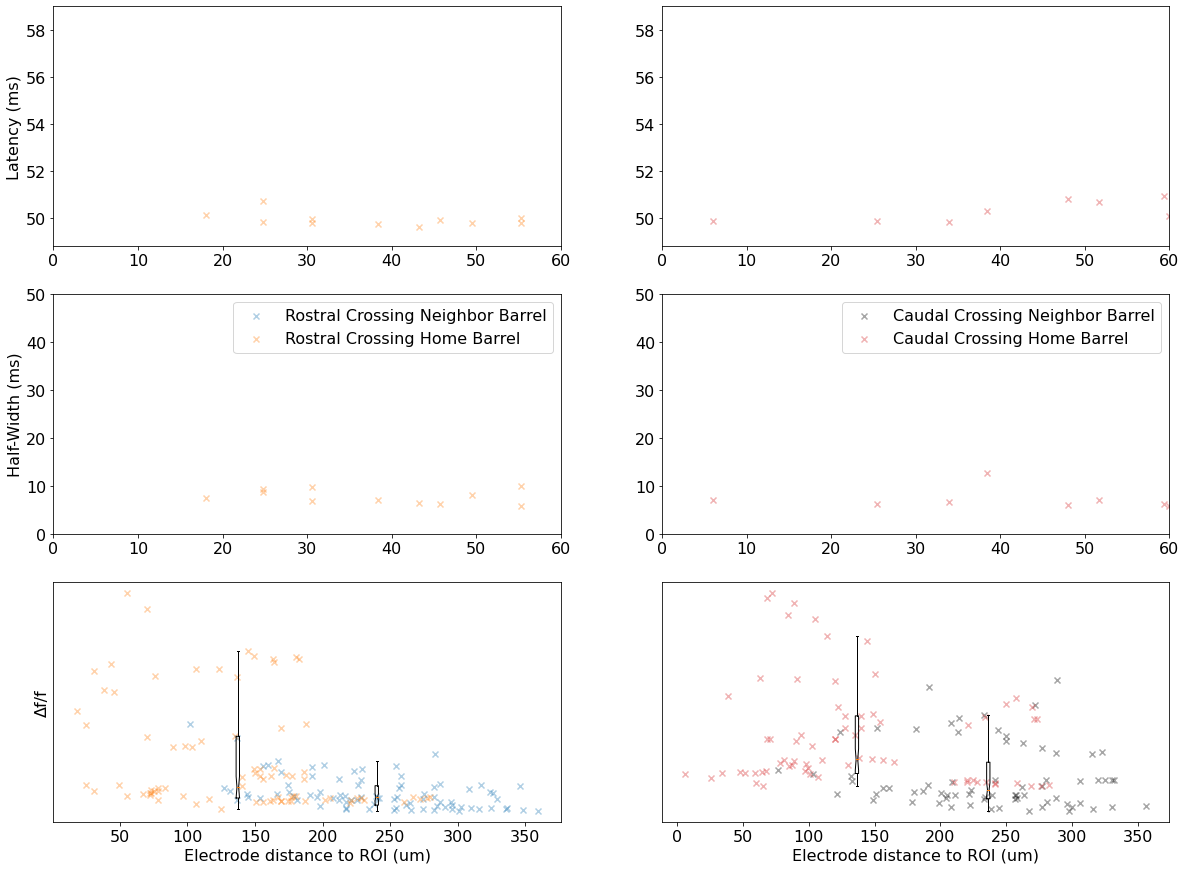

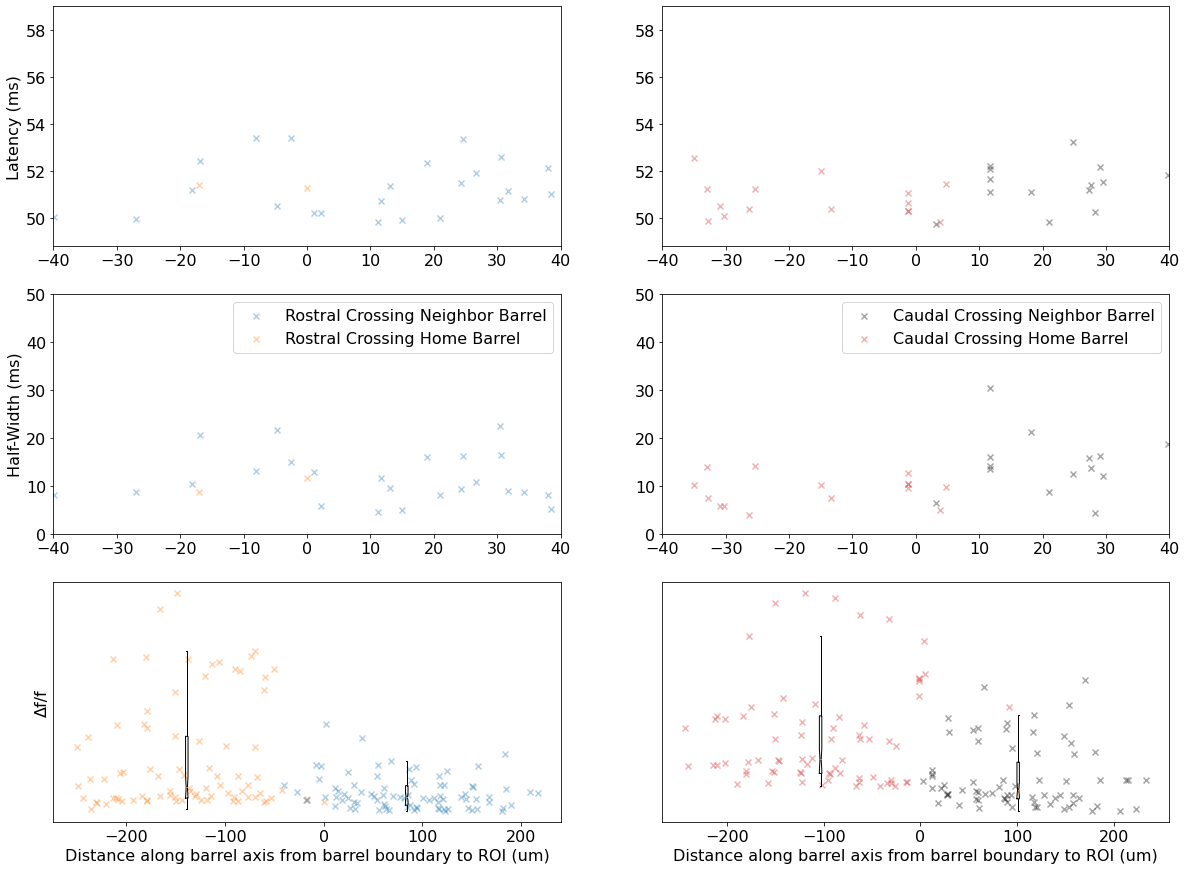

In [15]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff
amp_cutoff = None
if amp_cutoff is not None:
    pixel_df = pixel_df[pixel_df['Value'] > amp_cutoff]
plt.rcParams.update({'font.size': 16})
for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    handles = []
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    for i, direction in enumerate(crossing_directions):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]
        
        # split this out by whether Barrel == Home_Barrel or not
        home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
        neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

        lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 48.8)]
        hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
        lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 48.8)]
        hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
        amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
        amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]

        alph = 0.35
        l1 = ax[0][i].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l2 = ax[1][i].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l5 = ax[2][i].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l3 = ax[0][i].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        l4 = ax[1][i].scatter(hw_home[dist_type], hw_home['Value_hw'],
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        l6 = ax[2][i].scatter(amp_home[dist_type], amp_home['Value'],
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        
        # plot box and whisker plots for each group
        ax[0][i].boxplot([lat_neighbor['Value_lat']], positions=[np.mean(lat_neighbor[dist_type])], 
                         manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[1][i].boxplot([hw_neighbor['Value_hw']], positions=[np.mean(hw_neighbor[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[2][i].boxplot([amp_neighbor['Value']], positions=[np.mean(amp_neighbor[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[0][i].boxplot([lat_home['Value_lat']], positions=[np.mean(lat_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[1][i].boxplot([hw_home['Value_hw']], positions=[np.mean(hw_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[2][i].boxplot([amp_home['Value']], positions=[np.mean(amp_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        
        '''def plot_sig_bar(df_home, df_neighbor, dist_type, ax, i, j, height):
            lx = np.mean(df_home[dist_type])
            rx = np.mean(df_neighbor[dist_type])
            barx = [lx, lx, rx, rx]
            bary = [height, height * 1.01, height * 1.01, height]
            ax[j][i].plot(barx, bary, color='black')
            ax[j][i].annotate("p < 0.01", (np.mean([lx, rx])-3, height * 1.04), color='black', fontsize=12)
        # are there any significant differences between the groups
        # Welch's two-sided t-test 
        t_stat, p_val = ttest_ind(lat_home['Value_lat'], lat_neighbor['Value_lat'], alternative='two-sided', equal_var=False)
        if p_val < 0.05:
            plot_sig_bar(lat_home, lat_neighbor, dist_type, ax, i, 0, 55)
            
        print("p_val for latency home vs neighbor:", p_val)
        t_stat, p_val = ttest_ind(hw_neighbor['Value_hw'], hw_home['Value_hw'], alternative='two-sided',
                                    equal_var=False)
        if p_val < 0.05:
            plot_sig_bar(hw_neighbor, hw_home, dist_type, ax, i, 1, 32)

        print("p_val for half-width home vs neighbor:", p_val)
        t_stat, p_val = ttest_ind(amp_neighbor['Value'], amp_home['Value'], alternative='two-sided',
                                    equal_var=False)
        print("p_val for amp home vs neighbor:", p_val)
        if p_val < 0.05:
            plot_sig_bar(amp_neighbor, amp_home, dist_type, ax, i, 2, 0.008)'''

    ax[0][0].set_ylabel("Latency (ms)")
    ax[1][0].set_ylabel("Half-Width (ms)")
    ax[2][0].set_ylabel("Δf/f")
    ax[2][0].set_yticks([])
    ax[2][1].set_yticks([])
    for i in range(2):
        if dist_type == "Distance":
            ax[2][i].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):
        ax[0][i].set_ylim(48.8, 59)
        ax[1][i].set_ylim(0, 50)
        for j in range(2):
            if dist_type == "Distance":
                ax[j][i].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j][i].set_xlim(-40, 40)
        
    ax[1][0].legend()
    ax[1][1].legend()
    plt.show()

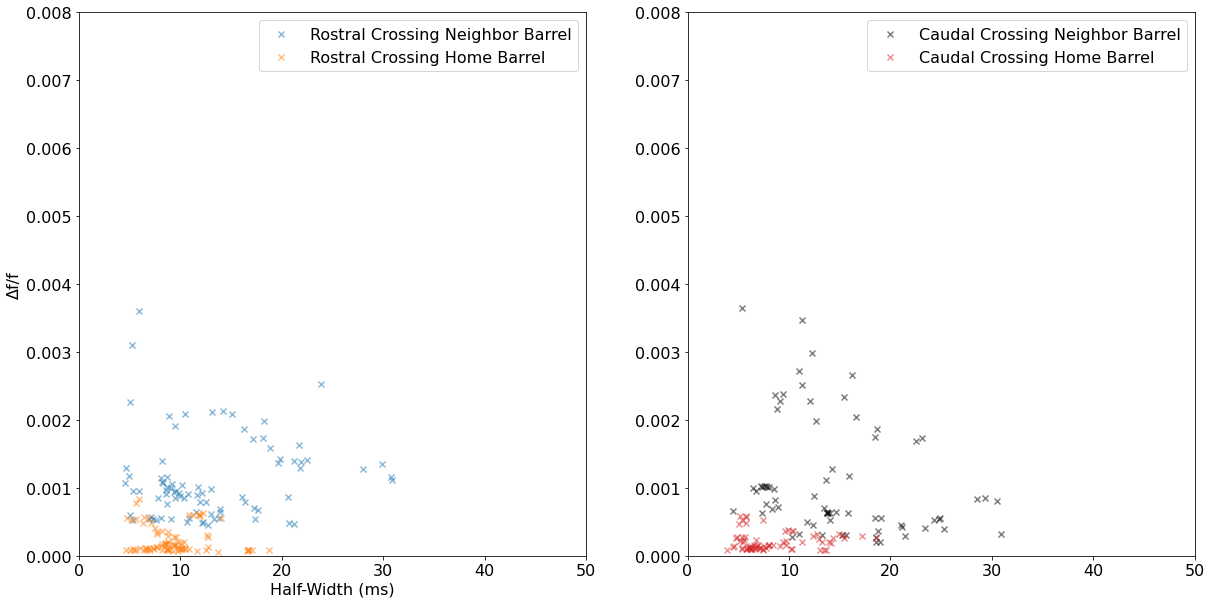

In [16]:
# Is there correlation between amplitude and half-width?
# Make a scatter plot of amplitude vs half-width
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_hw'], neighbor_barrel_df['Value'],
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_hw'], home_barrel_df['Value'] / 10, 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    '''ax[i].boxplot([neighbor_barrel_df['Value']], positions=[np.median(neighbor_barrel_df['Value_hw'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value']], positions=[np.median(home_barrel_df['Value_hw'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
    # plot horizontal boxplots for halfwidth
    ax[i].boxplot([neighbor_barrel_df['Value_hw']], positions=[np.median(neighbor_barrel_df['Value'])], 
                    manage_ticks=False, notch=False, widths=0.025, showfliers=False, vert=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value_hw']], positions=[np.median(home_barrel_df['Value'])],
                    manage_ticks=False, notch=False, widths=0.025, showfliers=False, vert=False, showbox=True)'''

# remove these tests in favor of Linear mixed effects model
'''    # are there any significant differences between the groups
    # Welch's two-sided t-test
    t_stat, p_val = ttest_ind(neighbor_barrel_df['Value'], home_barrel_df['Value'], alternative='two-sided', equal_var=False)
    print("p_val for amp home vs neighbor:", p_val)
    if p_val < 0.05:
        lx = np.median(home_barrel_df['Value_hw'])
        rx = np.median(neighbor_barrel_df['Value_hw'])
        barx = [lx, lx, rx, rx]
        bary = [0.1, 0.11, 0.11, 0.1]
        ax[i].plot(barx, bary, color='black')
        ax[i].annotate("p < 0.01", (np.mean([lx, rx])-0.5, 0.012), color='black', fontsize=12)

    # are there significant differences in half-width
    t_stat, p_val = ttest_ind(neighbor_barrel_df['Value_hw'], home_barrel_df['Value_hw'], alternative='two-sided', equal_var=False)
    print("p_val for hw home vs neighbor:", p_val)
    if p_val < 0.05:
        lx = np.median(home_barrel_df['Value'])
        rx = np.median(neighbor_barrel_df['Value'])
        barx = [lx, lx, rx, rx]
        bary = [0.1, 0.11, 0.11, 0.1]
        ax[i].plot(bary, barx, color='black')
        ax[i].annotate("p < 0.01", (0.012, np.mean([lx, rx])-0.5), color='black', fontsize=12)'''
ax[0].set_ylabel("Δf/f")
ax[0].set_xlabel("Half-Width (ms)")
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 0.008)

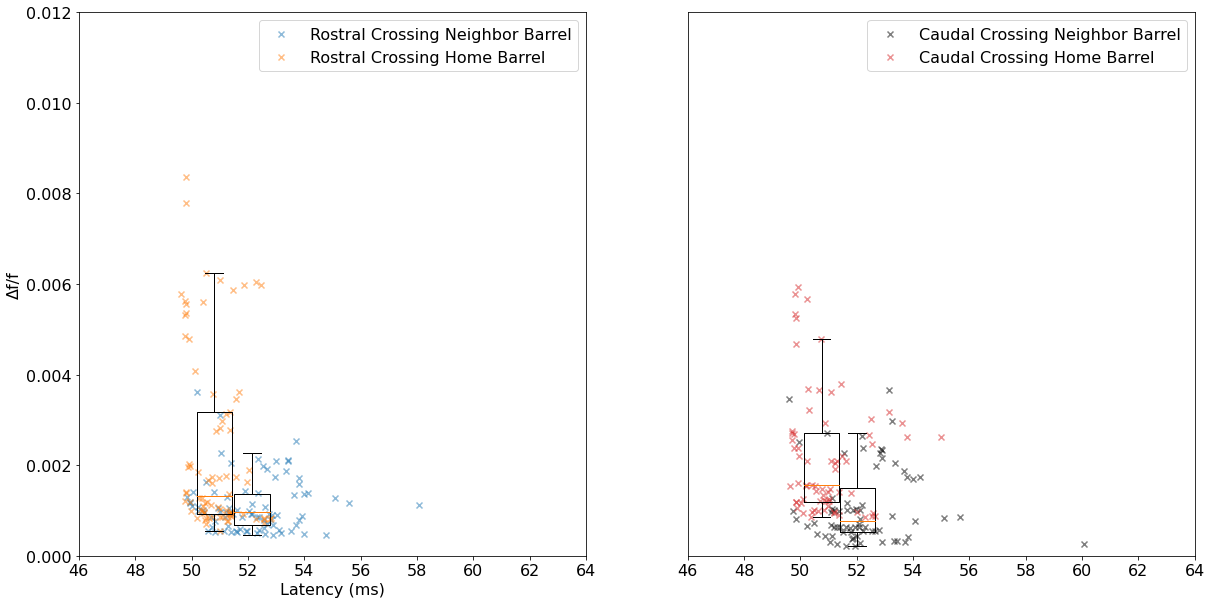

In [17]:
# is there correlation between latency and amplitude?
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_lat'], neighbor_barrel_df['Value'],
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_lat'], home_barrel_df['Value'], 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    ax[i].boxplot([neighbor_barrel_df['Value']], positions=[np.median(neighbor_barrel_df['Value_lat'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value']], positions=[np.median(home_barrel_df['Value_lat'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
ax[0].set_ylabel("Δf/f")
ax[0].set_xlabel("Latency (ms)")
ax[1].set_yticks([])
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(46, 64)
    ax[i].set_ylim(0, 0.012)
plt.show()

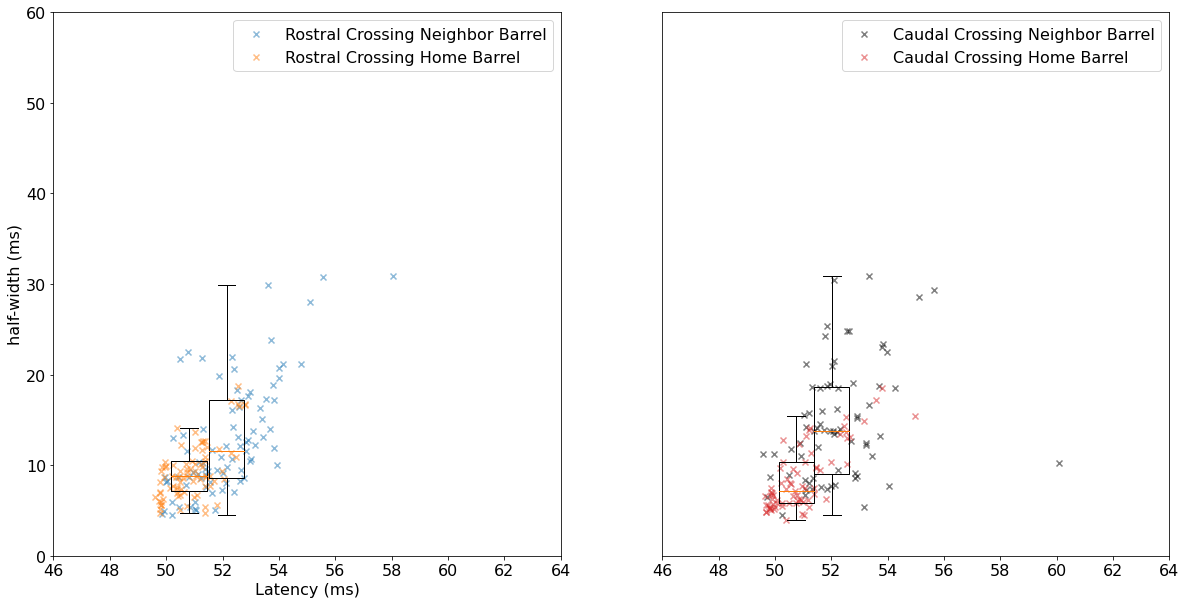

In [18]:
# correlation between half-width and latency?
# is there correlation between latency and amplitude?
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_lat'], neighbor_barrel_df['Value_hw'],
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_lat'], home_barrel_df['Value_hw'], 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    ax[i].boxplot([neighbor_barrel_df['Value_hw']], positions=[np.median(neighbor_barrel_df['Value_lat'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value_hw']], positions=[np.median(home_barrel_df['Value_lat'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
ax[0].set_ylabel("half-width (ms)")
ax[0].set_xlabel("Latency (ms)")
ax[1].set_yticks([])
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(46, 64)
    ax[i].set_ylim(0, 60)
plt.show()

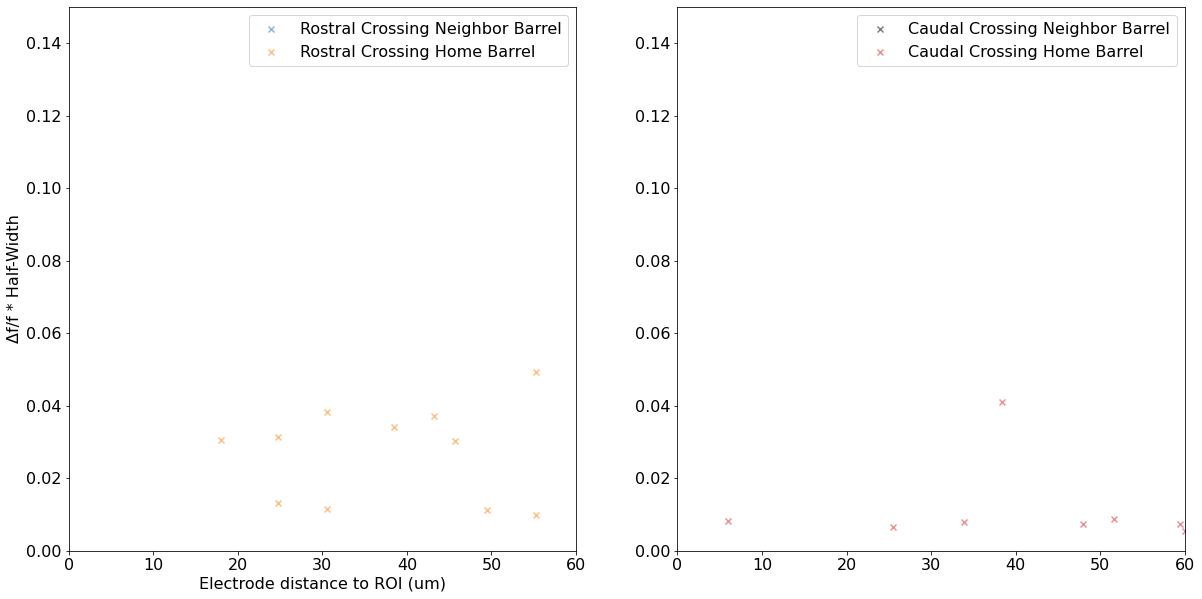

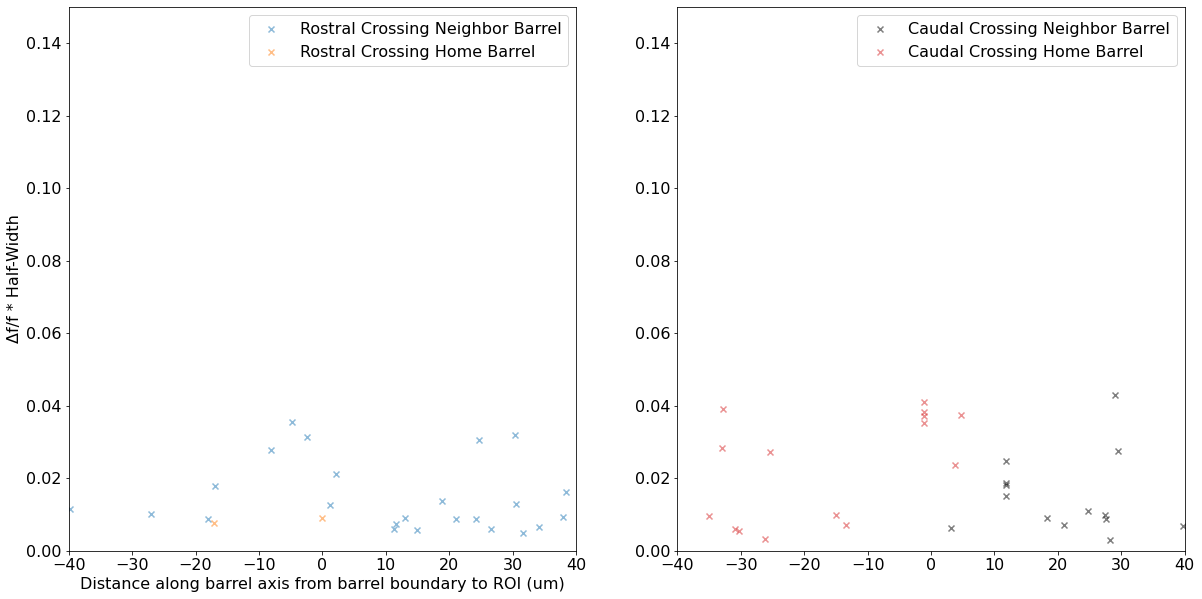

In [19]:
# scatter plot amp * hw versus distance
plt.rcParams.update({'font.size': 16})

for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, direction in enumerate(crossing_directions):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]
        # split this out by whether Barrel == Home_Barrel or not
        home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
        neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

        l1 = ax[i].scatter( neighbor_barrel_df[dist_type], neighbor_barrel_df['Value'] * neighbor_barrel_df['Value_hw'],
                            label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
        l2 = ax[i].scatter(home_barrel_df[dist_type], home_barrel_df['Value'] * home_barrel_df['Value_hw'], 
                            label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
        
        # boxplots 
        ax[i].boxplot([neighbor_barrel_df['Value'] * neighbor_barrel_df['Value_hw']], positions=[np.mean(neighbor_barrel_df[dist_type])], 
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[i].boxplot([home_barrel_df['Value'] * home_barrel_df['Value_hw']], positions=[np.mean(home_barrel_df[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[0].set_ylabel("Δf/f * Half-Width")
    if dist_type == "Distance":
        ax[0].set_xlabel("Electrode distance to ROI (um)")
    elif dist_type == "Distance_Along_Barrel_Axis":
        ax[0].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")        
    ax[0].legend()
    ax[1].legend()
    for i in range(2):
        if dist_type == "Distance":
            ax[i].set_xlim(0, 60)
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[i].set_xlim(-40, 40)
        ax[i].set_ylim(0, 0.15)
    plt.show()

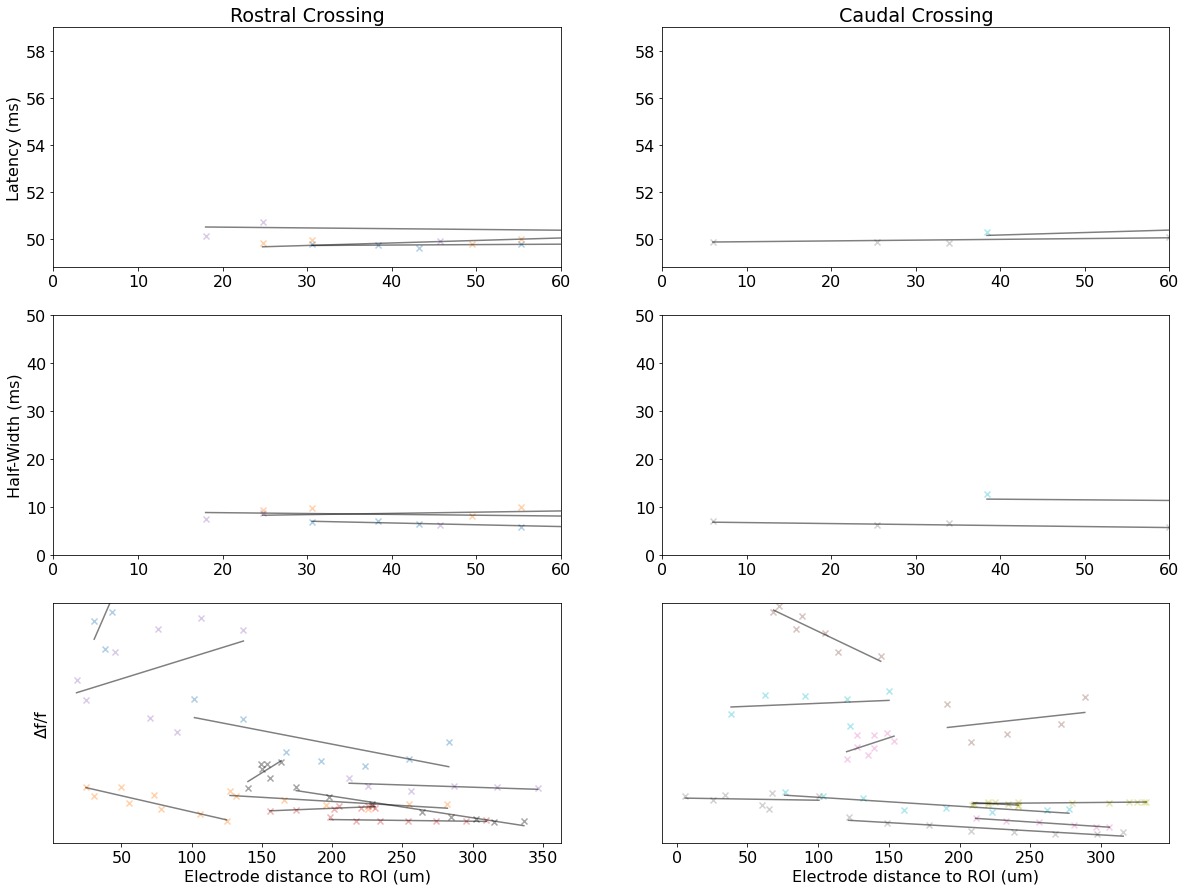

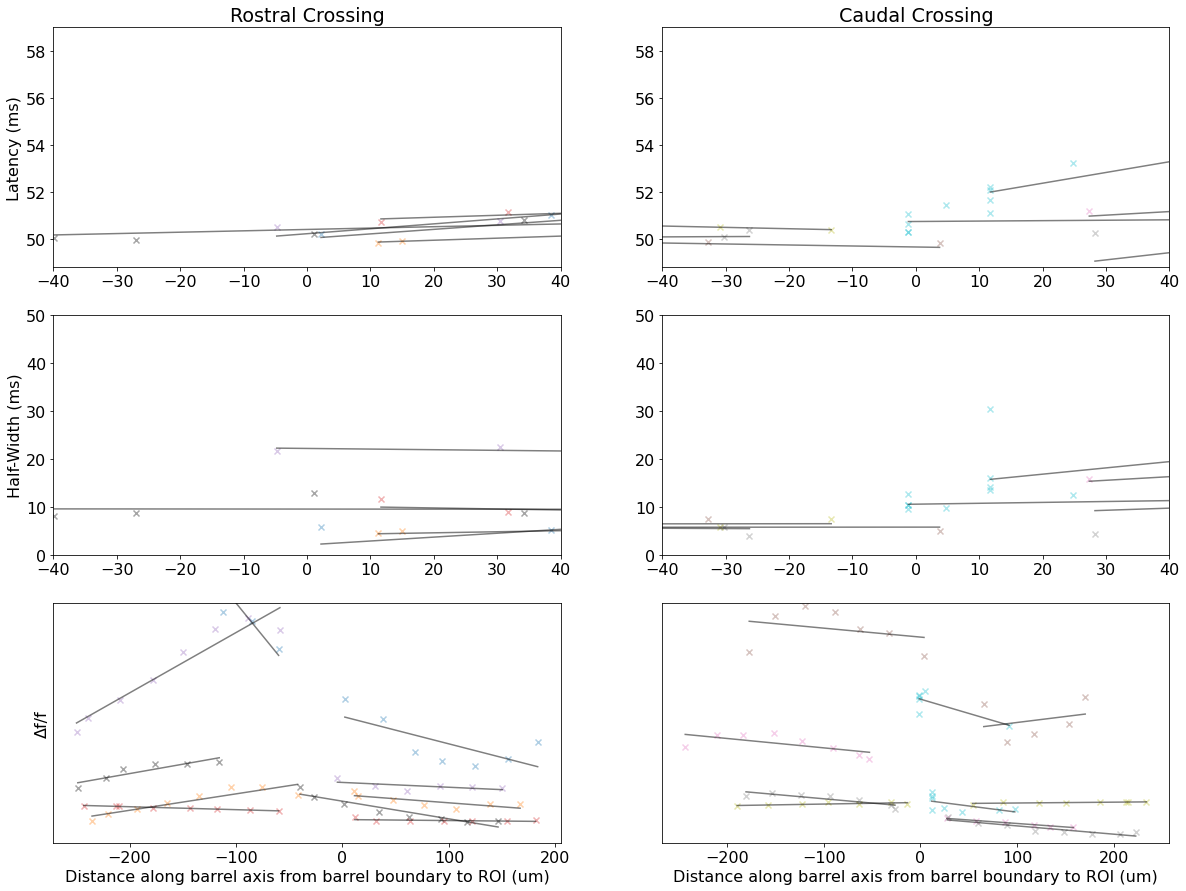

In [20]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff
amp_cutoff = None
if amp_cutoff is not None:
    pixel_df = pixel_df[pixel_df['Value'] > amp_cutoff]
plt.rcParams.update({'font.size': 16})
linear_regressions = {}
k = -1
for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    handles = []
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',]
    for i, direction in enumerate(crossing_directions):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]

        # use a different color for each slice/loc
        for jx, date in enumerate(df['Date'].unique()):
            df_date = df[df['Date'] == date]
            for jxx, slic_loc_id in enumerate(df_date['Slice_Loc'].unique()):
                j = jx + jxx
                df_slic_loc = df_date[(df_date['Slice_Loc'] == slic_loc_id)]

                # split this out by whether Barrel == Home_Barrel or not
                home_barrel_df = df_slic_loc[df_slic_loc['Barrel'] == df_slic_loc['Home_Barrel']]
                neighbor_barrel_df = df_slic_loc[df_slic_loc['Barrel'] != df_slic_loc['Home_Barrel']]

                lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 48.8)]
                hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
                lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 48.8)]
                hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
                amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
                amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]
                k = (k+1) % len(colors)

                alph = 0.35
                l1 = ax[0][i].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[k], marker='x')
                l2 = ax[1][i].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[k], marker='x')
                l5 = ax[2][i].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[k], marker='x')
                l3 = ax[0][i].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                                    label=direction + " Crossing Home Barrel", alpha=alph, c=colors[k], marker='x')
                l4 = ax[1][i].scatter(hw_home[dist_type], hw_home['Value_hw'],
                                    label=direction + " Crossing Home Barrel", alpha=alph, c=colors[k], marker='x')
                l6 = ax[2][i].scatter(amp_home[dist_type], amp_home['Value'],
                                    label=direction + " Crossing Home Barrel", alpha=alph, c=colors[k], marker='x')
                
                # fit a linear regression and plot a line for each slice/loc
                for ix, (home, neighbor, value_type) in enumerate([(lat_home, lat_neighbor, 'Value_lat'), 
                                                                   (hw_home, hw_neighbor, 'Value_hw'), 
                                                                   (amp_home, amp_neighbor, 'Value')]):
                    for ixx, df in enumerate([home, neighbor]):
                        if len(df) < 2:
                            continue
                        slope, intercept, r_value, p_value, std_err = linregress(df[dist_type], df[value_type])
                        x = np.linspace(min(df[dist_type]), max(df[dist_type]), 100)
                        y = slope * x + intercept
                        ax[ix][i].plot(x, y, color='black', alpha=0.5)

                # repeat the linear regression fits but with each set centered on its mean
                for ix, (home, neighbor, value_type) in enumerate([(lat_home, lat_neighbor, 'Value_lat'), 
                                                                   (hw_home, hw_neighbor, 'Value_hw'), 
                                                                   (amp_home, amp_neighbor, 'Value')]):
                    for ixx, df in enumerate([home, neighbor]):
                        if len(df) < 2:
                            continue
                        slope, intercept, r_value, p_value, std_err = linregress(df[dist_type] - np.mean(df[dist_type]), df[value_type])
                        x = np.linspace(min(df[dist_type]), max(df[dist_type]), 100)
                        y = slope * (x - np.mean(df[dist_type])) + intercept

                        if dist_type not in linear_regressions:
                            linear_regressions[dist_type] = {}
                        if direction not in linear_regressions[dist_type]:
                            linear_regressions[dist_type][direction] = {}
                        if value_type not in linear_regressions[dist_type][direction]:
                            linear_regressions[dist_type][direction][value_type] = {}
                        if ixx not in linear_regressions[dist_type][direction][value_type]:
                            linear_regressions[dist_type][direction][value_type][ixx] = {}
                        linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id] = [slope, intercept, r_value, p_value, std_err]

    ax[0][0].set_ylabel("Latency (ms)")
    ax[1][0].set_ylabel("Half-Width (ms)")
    ax[2][0].set_ylabel("Δf/f")
    ax[2][0].set_yticks([])
    ax[2][1].set_yticks([])
    for i in range(2):
        if dist_type == "Distance":
            ax[2][i].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):
        ax[0][i].set_ylim(48.8, 59)
        ax[1][i].set_ylim(0, 50)
        ax[2][i].set_ylim(0, 0.006)
        for j in range(2):
            if dist_type == "Distance":
                ax[j][i].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j][i].set_xlim(-40, 40)
        ax[0][i].set_title(crossing_directions[i] + " Crossing")
        
    #ax[1][0].legend()
    #ax[1][1].legend()
    plt.show()

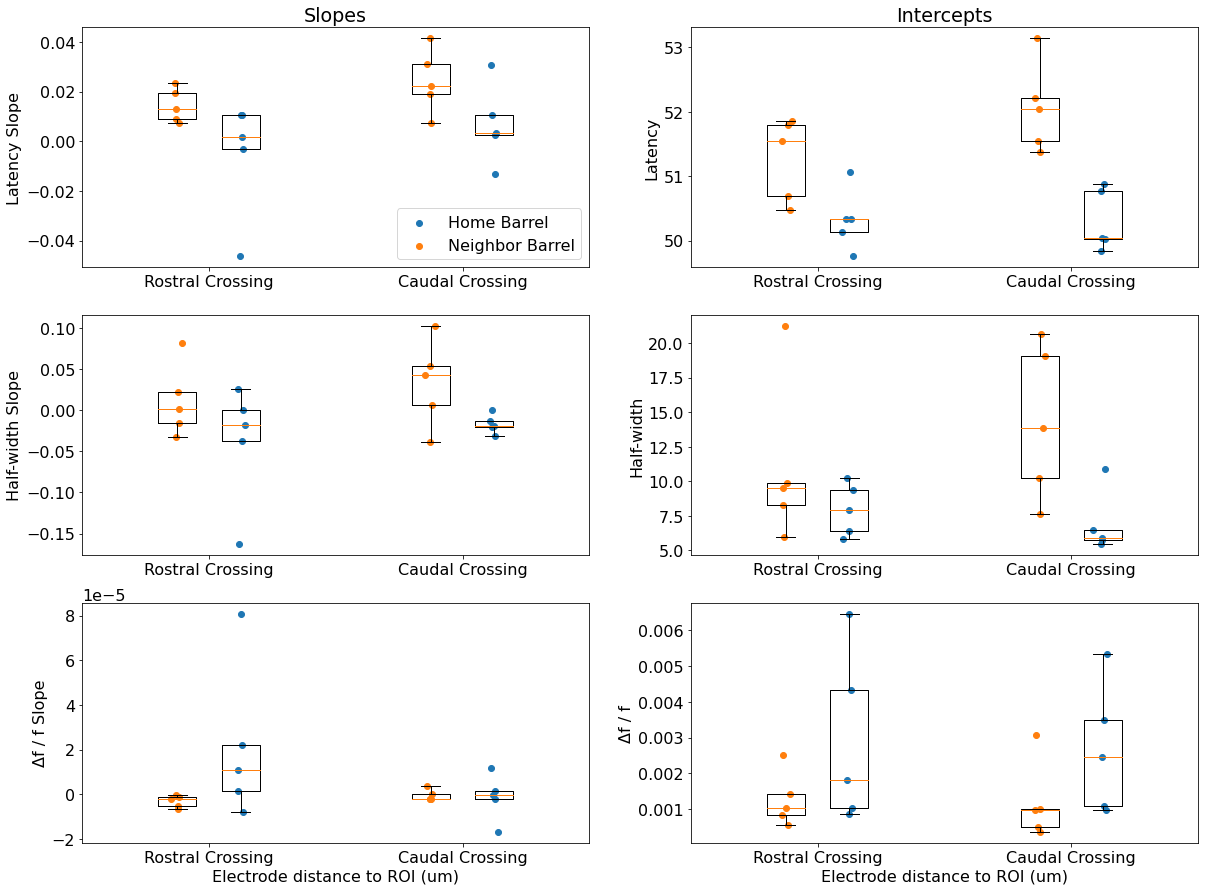

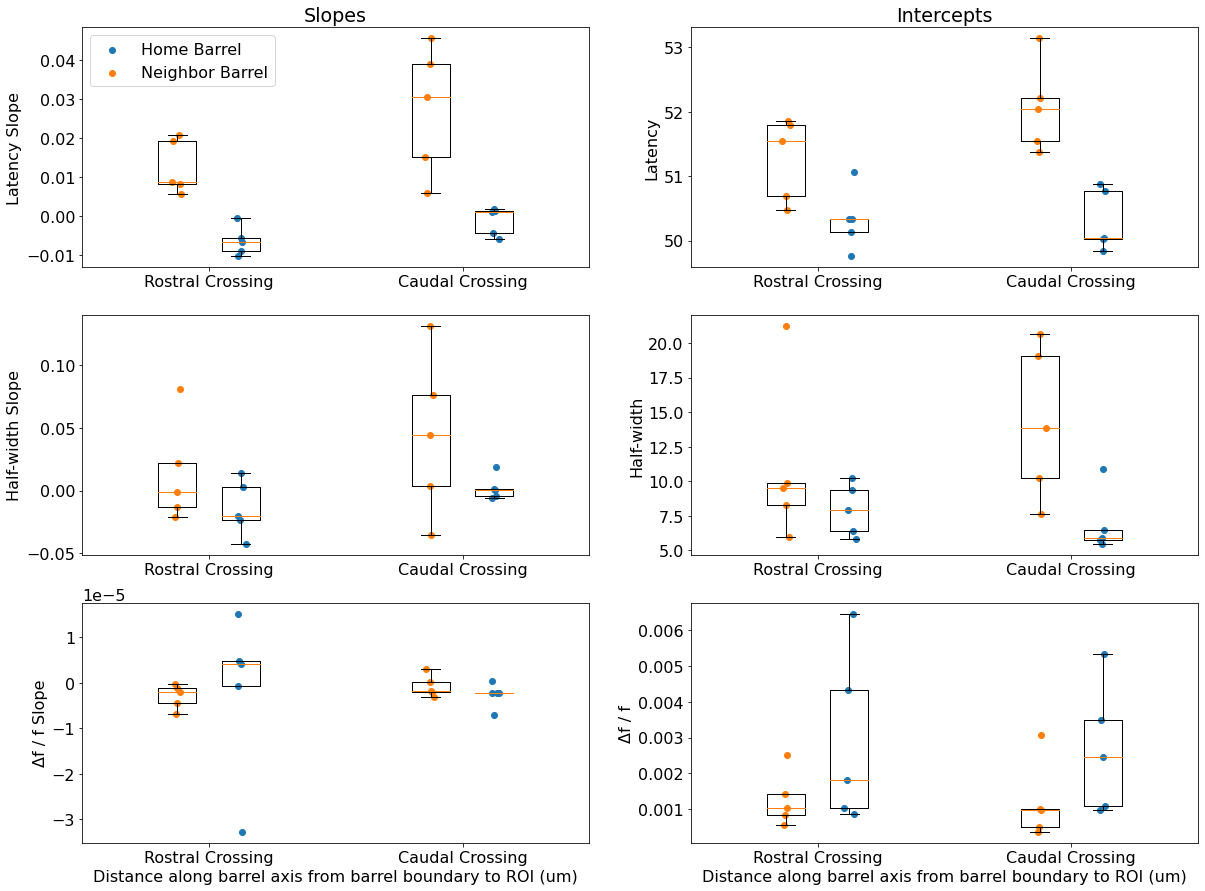

In [21]:
# plot distribution of each slope and intercept for each value type, direction, and distance type
colors = ['tab:blue','tab:orange', 'black', 'tab:green']
handles = []
for dist_type in linear_regressions:
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    for i, direction in enumerate(crossing_directions):
        for j, (value_type, value_name) in enumerate([['Value_lat', "Latency"], ['Value_hw', 'Half-width'], ['Value', 'Δf / f']]):
            for ixx, home_barrel in enumerate(["Home", "Neighbor"]):

                slopes = []
                intercepts = []
                for slic_loc_id in linear_regressions[dist_type][direction][value_type][ixx]:
                    slopes.append(linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id][0])
                    intercepts.append(linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id][1])
                x_jitter = np.random.normal(0, 0.01, len(slopes)) + i - (ixx * 0.25) + 0.125
                l = ax[j][0].scatter(x_jitter, slopes, label=home_barrel + " Barrel", c=colors[ixx])
                handles.append(l)
                x_jitter = np.random.normal(0, 0.01, len(intercepts)) + i - (ixx * 0.25) + 0.125
                ax[j][1].scatter(x_jitter, intercepts, label=direction, c=colors[ixx])

                # add boxplots
                ax[j][0].boxplot([slopes], positions=[i - (ixx * 0.25) + 0.125], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
                ax[j][1].boxplot([intercepts], positions=[i - (ixx * 0.25) + 0.125], manage_ticks=False, notch=False, widths=0.15, showfliers=False)


                ax[0][0].set_title("Slopes")
                ax[0][1].set_title("Intercepts")
                ax[j][i].set_xlim(-0.5, 1.5)
                ax[j][i].set_xticks([])
                ax[j][i].set_xticks([0, 1])
                ax[j][i].set_xticklabels([cd + " Crossing" for cd in crossing_directions])
                ax[j][0].set_ylabel(value_name + " Slope")
                ax[j][1].set_ylabel(value_name)
                if dist_type == "Distance":
                    ax[2][i].set_xlabel("Electrode distance to ROI (um)")
                elif dist_type == "Distance_Along_Barrel_Axis":
                    ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")


    ax[0][0].legend(handles=[handles[0], handles[-1]], labels=["Home Barrel", "Neighbor Barrel"])
    plt.show()

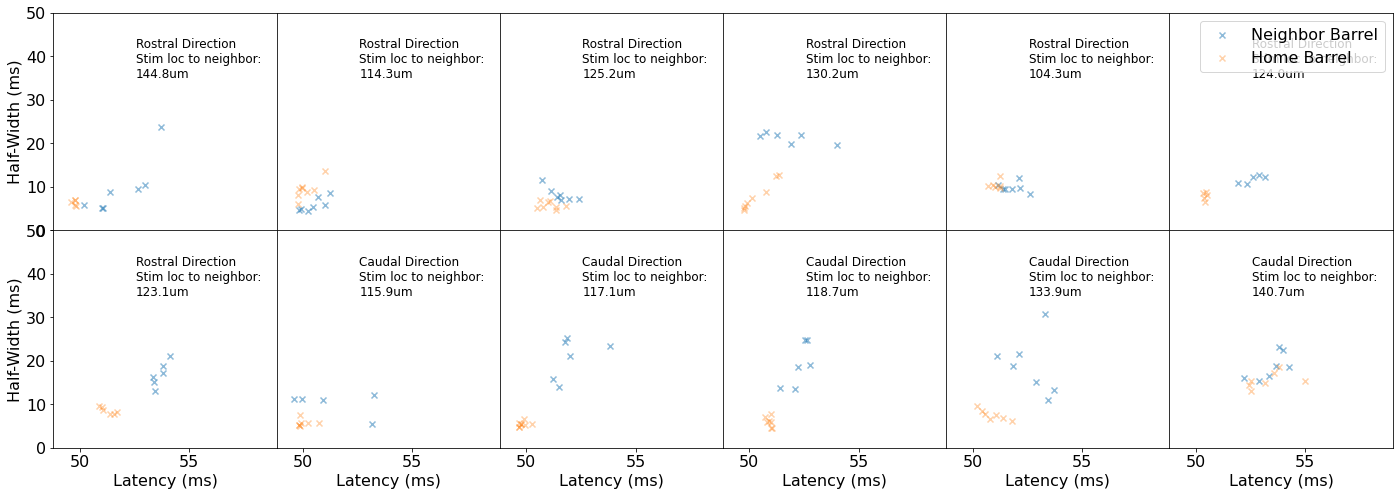

Total plots: 12


In [22]:
# create visualization of half-width versus latency with a different color for each slice/loc
plt.rcParams.update({'font.size': 16})
n_rows = 2
fig, ax = plt.subplots(2, 6, figsize=(24, n_rows * 4))
plt.subplots_adjust(wspace=0, hspace=0)

k_plot = 0
for i, direction in enumerate(crossing_directions):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    

    for jx, date in enumerate(df['Date'].unique()):
        df_date = df[df['Date'] == date]
        for jxx, slic_loc_id in enumerate(df_date['Slice_Loc'].unique()):
            j = jx + jxx
            df_slic_loc = df_date[(df_date['Slice_Loc'] == slic_loc_id)]

            # do not plot if stim_distance2 not centered, esp. stim is too close to the barrel boundary
            stim_dist2 = df_slic_loc['Stim_Distance2'].values[0]
            if not (100 < stim_dist2 < 150):
                continue

            # split this out by whether Barrel == Home_Barrel or not
            home_barrel_df = df_slic_loc[df_slic_loc['Barrel'] == df_slic_loc['Home_Barrel']]
            neighbor_barrel_df = df_slic_loc[df_slic_loc['Barrel'] != df_slic_loc['Home_Barrel']]

            i_plot = k_plot % 6
            j_plot = k_plot // 6

            l1 = ax[j_plot][i_plot].scatter( neighbor_barrel_df['Value_lat'], neighbor_barrel_df['Value_hw'],
                                label=direction + " Crossing Neighbor Barrel", alpha=0.5, marker='x')

            l2 = ax[j_plot][i_plot].scatter(home_barrel_df['Value_lat'], home_barrel_df['Value_hw'], 
                                label=direction + " Crossing Home Barrel", alpha=0.35, c='tab:orange', marker='x')
            
            ax[j_plot][i_plot].annotate(direction + " Direction\nStim loc to neighbor:\n" + str(stim_dist2)[:5] + "um", 
                                        (0.37, 0.7), xycoords='axes fraction', fontsize=12)
            
            k_plot += 1

for i in range(6):
    for j in range(n_rows):
        ax[j][i].set_xlim(48.8, 59)
        ax[j][i].set_ylim(0, 50)

        if j == n_rows - 1:
            ax[j][i].set_xlabel("Latency (ms)")
        else:
            ax[j][i].set_xticks([])
        if i == 0:
            ax[j][i].set_ylabel("Half-Width (ms)")
        else:
            ax[j][i].set_yticks([])
ax[0][5].legend(handles=[l1, l2], labels=["Neighbor Barrel", "Home Barrel"])
plt.show()
print("Total plots:", k_plot)


In [23]:
# merge coronal and sagittal data
merge_data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
coronal_df = pd.read_csv(merge_data_dir + "coronal-crossing/coronal_crossing_final_by_" + roi_type + ".csv")
sagittal_df = pd.read_csv(merge_data_dir + "sagittal/sagittal_crossing_final_by_" + roi_type + ".csv")

# mark the slice/loc as coronal or sagittal
coronal_df['Is_Sagittal'] = 0
sagittal_df['Is_Sagittal'] = 1

# merge the two dataframes
merged_df = pd.concat([coronal_df, sagittal_df])
stim_time_actual = 48.35  # actual stim time
merged_df['Value_lat'] -= stim_time_actual
merged_df['Max_Amp_Time'] -= stim_time_actual
merged_df.to_csv(merge_data_dir + "merged_crossing_final_by_" + roi_type + ".csv", index=False)
merged_df

,Date,Slice_Loc,ROI,Value,Value_hw,Max_Amp_Time,Value_lat,Distance,Distance_Along_Barrel_Axis,Barrel,...,Slice,Loc,Is_Home_Barrel,Is_Lateral_Crossing,Animal,Litter,Age,Sex,Is_Sagittal,Is_Rostral_Crossing
0,6/25/2024,3_1,1,0.000793,12.2953,4.900454,3.5026,170.762994,27.244597,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
1,6/25/2024,3_1,2,0.000645,17.7750,10.897859,3.4950,193.214906,55.578977,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
2,6/25/2024,3_1,3,0.000545,17.3931,6.399019,3.8332,231.758495,88.000047,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
3,6/25/2024,3_1,4,0.000469,17.1436,11.401010,4.1567,267.589237,119.603779,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
4,6/25/2024,3_1,5,0.000485,19.7282,12.896033,4.8331,278.919343,128.866942,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,6/4/2024,4_2,3,0.001735,18.1069,9.399131,4.6176,258.278919,117.130321,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0
305,6/4/2024,4_2,4,0.001344,29.8651,11.400565,5.2690,282.255204,150.863854,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0
306,6/4/2024,4_2,5,0.001271,27.9799,13.398409,6.7454,308.110370,184.597387,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0
307,6/4/2024,4_2,6,0.001160,30.7221,15.900000,7.2281,323.610877,208.960493,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0


p_val for mean latency coronal vs sagittal: 0.06323857919979714
p_val for std Value_lat coronal vs sagittal: 0.3186821730095
p_val for mean latency coronal vs sagittal: 0.5891927608948605
p_val for std Value_hw coronal vs sagittal: 0.3908115791505792


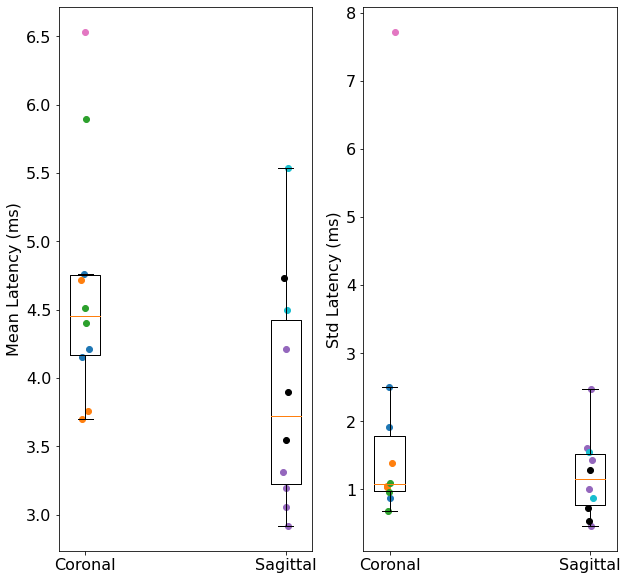

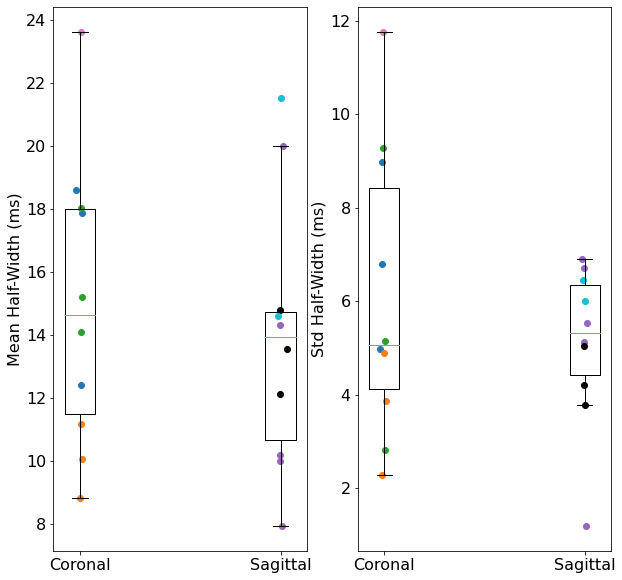

In [24]:
# visualize coronal verus sagittal data by plotting distributions of latency and half-width for neighbor barrels
plt.rcParams.update({'font.size': 16})
df = merged_df[(merged_df['Barrel'] != merged_df['Home_Barrel'])]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'black',  'tab:cyan', 'tab:gray', 'tab:olive']
color_by_date = {date: colors[i] for i, date in enumerate(df['Date'].unique())}
# split slic/loc column into slice and loc columns
df = df[df['Value_hw'] > 0]
df['Slice'] = df['Slice_Loc'].apply(lambda x: int(x.split("_")[0]))
df['Loc'] = df['Slice_Loc'].apply(lambda x: int(x.split("_")[1]))

# group by date and slice/loc and get mean and std of latency
grouped = df.groupby(['Date', 'Slice', 'Is_Sagittal'])
for response_type in ['Value_lat', 'Value_hw']:
    means = grouped[response_type].mean().reset_index()
    stds = grouped[response_type].std().reset_index()

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'black',  'tab:cyan', 'tab:gray', 'tab:olive']
    color_by_date = {date: colors[i] for i, date in enumerate(df['Date'].unique())}

    means_ = {"Coronal": [],
            "Sagittal": []}
    stds_ = {"Coronal": [],
                "Sagittal": []}
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    for i, is_sagittal in enumerate([0, 1]):
        df_is_sagittal = df[df['Is_Sagittal'] == is_sagittal]
        for j, date in enumerate(df_is_sagittal['Date'].unique()):
            df_date = df_is_sagittal[df_is_sagittal['Date'] == date]
            for jx, slic_id in enumerate(df_date['Slice'].unique()):
                df_slic = df_date[(df_date['Slice'] == slic_id)]

                x_jitter = (np.random.normal(0, 0.01, len(df_slic)) + i)
                

                # plot the mean and std, average over all locations in the slice
                mean = means[(means['Date'] == date) & (means['Slice'] == slic_id) & (means['Is_Sagittal'] == is_sagittal)][response_type].values[0]
                std = stds[(stds['Date'] == date) & (stds['Slice'] == slic_id) & (stds['Is_Sagittal'] == is_sagittal)][response_type].values[0]
                
                if is_sagittal:
                    l2 = ax[0].scatter(x_jitter[0], mean, label="Sagittal", c=color_by_date[date])
                    ax[1].scatter(x_jitter[1], std, label="Sagittal",  c=color_by_date[date])
                    stds_["Sagittal"].append(std)
                    means_["Sagittal"].append(mean)
                else:
                    l1 = ax[0].scatter(x_jitter[0], mean, label="Coronal", c=color_by_date[date])
                    ax[1].scatter(x_jitter[1], std, label="Coronal",  c=color_by_date[date])
                    stds_["Coronal"].append(std)
                    means_["Coronal"].append(mean)

    if response_type == 'Value_lat':
        ax[0].set_ylabel("Mean Latency (ms)")
        ax[1].set_ylabel("Std Latency (ms)")
    elif response_type == 'Value_hw':
        ax[0].set_ylabel("Mean Half-Width (ms)")
        ax[1].set_ylabel("Std Half-Width (ms)")

    # boxplots
    ax[0].boxplot([means_["Coronal"], means_["Sagittal"]], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
    ax[1].boxplot([stds_["Coronal"], stds_["Sagittal"]], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)

    # significance tests between coronal and sagittal (Welch's t-test)
    t_stat, p_val = ttest_ind(means_["Coronal"], means_["Sagittal"], alternative='two-sided', equal_var=False)
    print("p_val for mean latency coronal vs sagittal:", p_val)
    if p_val < 0.05:
        ax[0].plot([0, 1], [58, 58], color='black')
        ax[0].annotate("p = " + str(p_val)[:5], (0.4, 58.3), color='black', fontsize=12)

    t_stat, p_val = ttest_ind(stds_["Coronal"], stds_["Sagittal"], alternative='two-sided', equal_var=False)
    print("p_val for std "+ response_type +" coronal vs sagittal:", p_val)
    if p_val < 0.05:
        ax[1].plot([0, 1], [8.5, 8.5], color='black')
        ax[1].annotate("p = " + str(p_val)[:5], (0.4, 8.85), color='black', fontsize=12)
                    

    for i in range(2):
        ax[i].set_xticks([0, 1])
        ax[i].set_xticklabels(["Coronal", "Sagittal"])

response type: Value_lat regression_sig_counter: [38, 13]
Value_lat Mean slope coronal: 0.012036358146712205 std: 0.002049252668665403
Value_lat Mean slope sagittal: 0.01641981447921762 std: 0.003392919197491577
Value_lat Mean intercept coronal: 3.2388949167334196 std: 0.33564237266349123
Value_lat Mean intercept sagittal: 2.2579976631299488 std: 0.3512435670457616


Mean velocity coronal: 83.08160888957556 std: 18.166910301777165
Mean velocity sagittal: 60.90202792885932 std: 14.628895348043132
p_val for slope coronal vs sagittal: 0.2883431395381056
p_val for intercept coronal vs sagittal: 0.05971974360833588
82     11.648704
83     31.617911
84     63.235822
85     94.853734
86    121.479343
87    154.761355
88    181.386964
Name: Distance_Along_Barrel_Axis, dtype: float64 82    11.57660
83     9.05797
84     7.62517
85     8.14644
86     6.94209
87     7.27715
88     7.09651
Name: Value_hw, dtype: float64
response type: Value_hw regression_sig_counter: [17, 34]
Value_hw Mean slope c

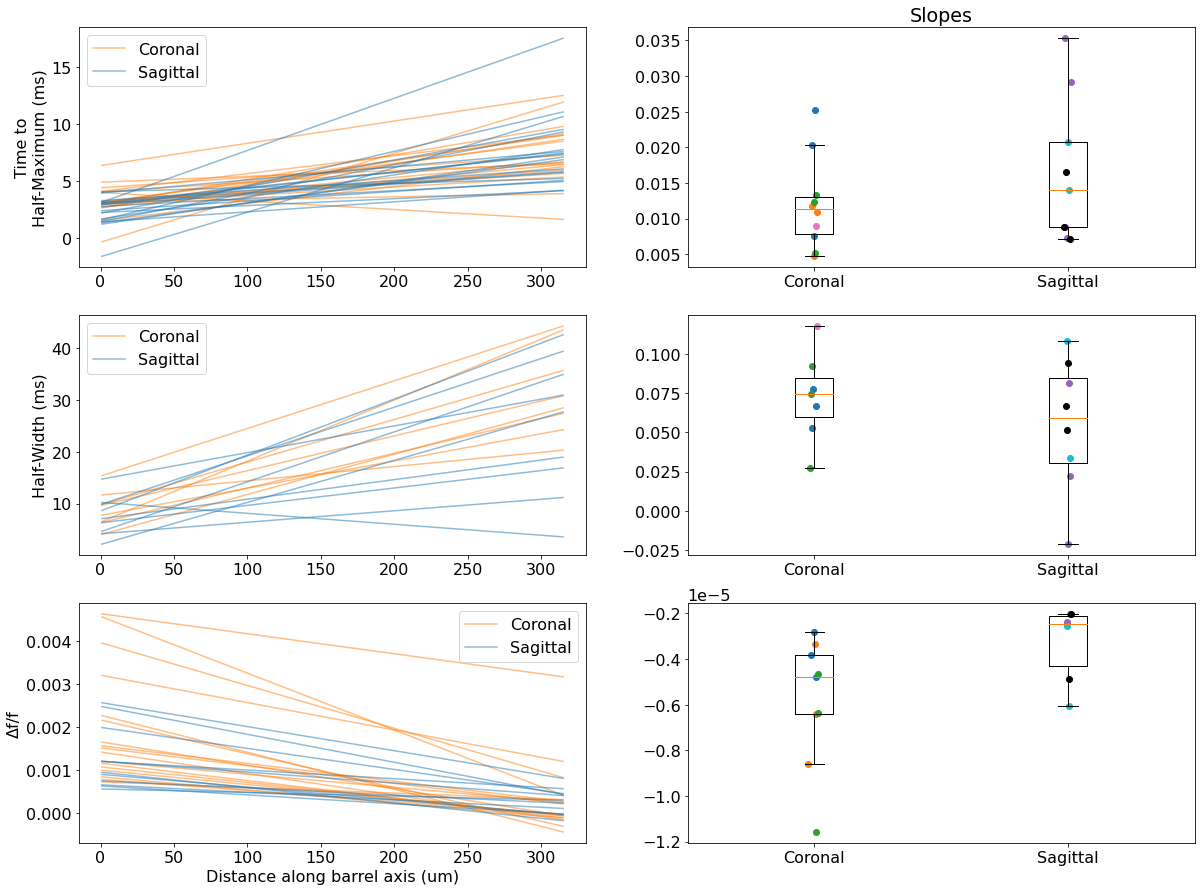

FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions: [0.41275123 0.17915923 0.41275123 0.61894937 0.17915923 0.21441285]


In [32]:
# plot linear regressions for neighbor barrel, coronal versus sagittal
plt.rcParams.update({'font.size': 16})

predictor = 'Distance_Along_Barrel_Axis'
barrel = 'neighbor'
p_vals = []
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
for i_plotrow, response_type in enumerate(['Value_lat',  'Value_hw', 'Value']): # 'Max_Amp_Time',
    
    df = merged_df[(merged_df['Value_hw'] > 0) & 
                   (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
    
    if barrel == 'neighbor':
        df = df[(df['Barrel'] != df['Home_Barrel'])]  # restrict to neighbor barrels
    elif barrel == 'home':
        df = df[(df['Barrel'] == df['Home_Barrel'])]

    df = df[df[response_type] > 0]  # remove any negative values
    linear_regressions = {'coronal': [], 'sagittal': []}
    lin_intercepts = {'coronal': [], 'sagittal': []}
    x_jitter_1 = np.random.normal(0, 0.01, 400)
    x_jitter_2 = np.random.normal(0, 0.01, 400) + 1
    handles = []
    i_jit = 0
    regression_sig_counter = [0, 0]
    for i, is_sagittal in enumerate([0, 1]):
        df_is_sagittal = df[df['Is_Sagittal'] == is_sagittal]

        # for each date
        for j, date in enumerate(df_is_sagittal['Date'].unique()):
            df_date = df_is_sagittal[df_is_sagittal['Date'] == date]

            
            for jx, slic_id in enumerate(df_date['Slice'].unique()):
                df_slic = df_date[(df_date['Slice'] == slic_id)]

                # for each location, fit a linear regression
                slice_slopes = []
                slice_intercepts = []
                for jxx, loc_id in enumerate(df_slic['Loc'].unique()):
                    df_loc = df_slic[df_slic['Loc'] == loc_id]
                    if len(df_loc) < 3:
                        continue

                    # fit linear regression for latency and distance along barrel axis
                    slope, intercept, r_value, p_value, std_err = linregress(df_loc[predictor], df_loc[response_type])
                    if p_value < 0.05:  # lower p-value threshold to account for FDR
                        regression_sig_counter[0] += 1
                        if slope < 0 and response_type == 'Value_hw':
                            print(df_loc[predictor], df_loc[response_type])
                        slice_slopes.append(slope)
                        slice_intercepts.append(intercept)
                        
                        x = np.linspace(min(df[predictor]), max(df[predictor]), 100)
                        y = slope * x + intercept
                        l1 = ax[i_plotrow][0].plot(x, y, alpha=0.5, c=("tab:blue" if is_sagittal else "tab:orange"), label=("Sagittal" if is_sagittal else "Coronal"))
                        handles.append(l1[0])
                    else:
                        regression_sig_counter[1] += 1

                # plot the mean of the slopes and intercepts for each slice
                if len(slice_slopes) > 0:
                    if is_sagittal:
                        linear_regressions['sagittal'].append(np.mean(slice_slopes))
                        lin_intercepts['sagittal'].append(np.mean(slice_intercepts))
                        ax[i_plotrow][1].scatter(x_jitter_2[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                        #ax[i_plotrow][2].scatter(x_jitter_2[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                    else:
                        linear_regressions['coronal'].append(np.mean(slice_slopes))
                        lin_intercepts['coronal'].append(np.mean(slice_intercepts))
                        ax[i_plotrow][1].scatter(x_jitter_1[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                        #ax[i_plotrow][2].scatter(x_jitter_1[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                    i_jit += 1
    print("response type:", response_type, "regression_sig_counter:", regression_sig_counter)

    # add boxplots
    ax[i_plotrow][1].boxplot([linear_regressions['coronal'], linear_regressions['sagittal']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
    #ax[i_plotrow][2].boxplot([lin_intercepts['coronal'], lin_intercepts['sagittal']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)

    # print the mean and std of the slopes and intercepts for this response type
    print(response_type, "Mean slope coronal:", np.mean(linear_regressions['coronal']), "std:", sem(linear_regressions['coronal']))
    print(response_type, "Mean slope sagittal:", np.mean(linear_regressions['sagittal']), "std:", sem(linear_regressions['sagittal']))
    print(response_type, "Mean intercept coronal:", np.mean(lin_intercepts['coronal']), "std:", sem(lin_intercepts['coronal']))
    print(response_type, "Mean intercept sagittal:", np.mean(lin_intercepts['sagittal']), "std:", sem(lin_intercepts['sagittal']))
    if response_type == 'Value_lat':
        print("\n")
        print("Mean velocity coronal:", 
        1 / np.mean(linear_regressions['coronal']), 
        "std:", sem([1 / float(x) for x in linear_regressions['coronal']]))
        print("Mean velocity sagittal:",
        1 / np.mean(linear_regressions['sagittal']),
        "std:", sem([1 / float(x) for x in linear_regressions['sagittal']]))

    # significance tests between coronal and sagittal (Welch's t-test)
    t_stat, p_val1 = ttest_ind(linear_regressions['coronal'], linear_regressions['sagittal'], alternative='two-sided', equal_var=False)
    print("p_val for slope coronal vs sagittal:", p_val1)
    t_stat, p_val2 = ttest_ind(lin_intercepts['coronal'], lin_intercepts['sagittal'], alternative='two-sided', equal_var=False)
    print("p_val for intercept coronal vs sagittal:", p_val2)

    p_vals.append(p_val1)
    p_vals.append(p_val2)

    # add significance lines
    '''if p_val1 < 0.05:
        ax[i_plotrow][1].plot([0, 1], [0.5, 0.5], color='black')
        ax[i_plotrow][1].annotate("p = " + str(round(p_val1, 2)), (0.4, 0.505), color='black', fontsize=12)
    if p_val2 < 0.05:
        ax[i_plotrow][2].plot([0, 1], [55, 55], color='black')
        ax[i_plotrow][2].annotate("p = " + str(round(p_val2, 2)), (0.4, 55.1), color='black', fontsize=12)'''

    ax[i_plotrow][0].legend(handles=[handles[0], handles[-1]], labels=["Coronal", "Sagittal"])
    for i in range(1,2):
        ax[i_plotrow][i].set_xticks([0, 1])
        ax[i_plotrow][i].set_xticklabels(["Coronal", "Sagittal"])
        ax[i_plotrow][i].set_xlim(-0.5, 1.5)

    if predictor == 'Distance_Along_Barrel_Axis' or predictor == 'Distance':
        if response_type == 'Value_lat':            
            ax[i_plotrow][0].set_ylabel("Time to\nHalf-Maximum (ms)")
        elif response_type == 'Value_hw':
            ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
        elif response_type == 'Value':
            ax[i_plotrow][0].set_ylabel("Δf/f")
        elif response_type == 'Max_Amp_Time':
            ax[i_plotrow][0].set_ylabel("Time to Peak (ms)")

    elif predictor == 'Value_hw':
        if response_type == 'Value_lat':
            ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
            ax[i_plotrow][0].set_ylabel("Latency (ms)")

        elif response_type == 'Value_hw':
            ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
            ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
        
ax[0][1].set_title("Slopes")
#ax[0][2].set_title("Intercepts")
ax[2][0].set_xlabel("Distance along barrel axis (um)")

plt.savefig("P:/John/crossing-paper/input/output-coronal-sagittal.png")
plt.show()

p_vals = false_discovery_control(p_vals)
print("FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions:", p_vals)


Value_lat Mean slope L2/3: 0.016273981261158803 std: 0.0028811792189712307
Value_lat Mean slope L4: 0.01545478585912024 std: 0.002201342094260442
Value_lat Mean intercept L2/3: 2.7285470938880994 std: 0.30950321028771294
Value_lat Mean intercept L4: 2.3799161244278575 std: 0.38659505498113644
p_val for slope L2/3 vs L4: 0.823438162587539
p_val for intercept L2/3 vs L4: 0.4929866947184425
Value_hw Mean slope L2/3: 0.07791779556013434 std: 0.007870886384157793
Value_hw Mean slope L4: 0.04739045570377907 std: 0.017985136325442658
Value_hw Mean intercept L2/3: 8.48711481607602 std: 1.1181678388879477
Value_hw Mean intercept L4: 7.012035112943239 std: 1.6174502624001221
p_val for slope L2/3 vs L4: 0.2234940666601302
p_val for intercept L2/3 vs L4: 0.49319795199580596
Value Mean slope L2/3: -4.23678509532155e-06 std: 6.62513286992528e-07
Value Mean slope L4: -8.609950555309168e-06 std: 2.648672109716188e-06
Value Mean intercept L2/3: 0.00153678049600688 std: 0.00027274459323094744
Value Mean

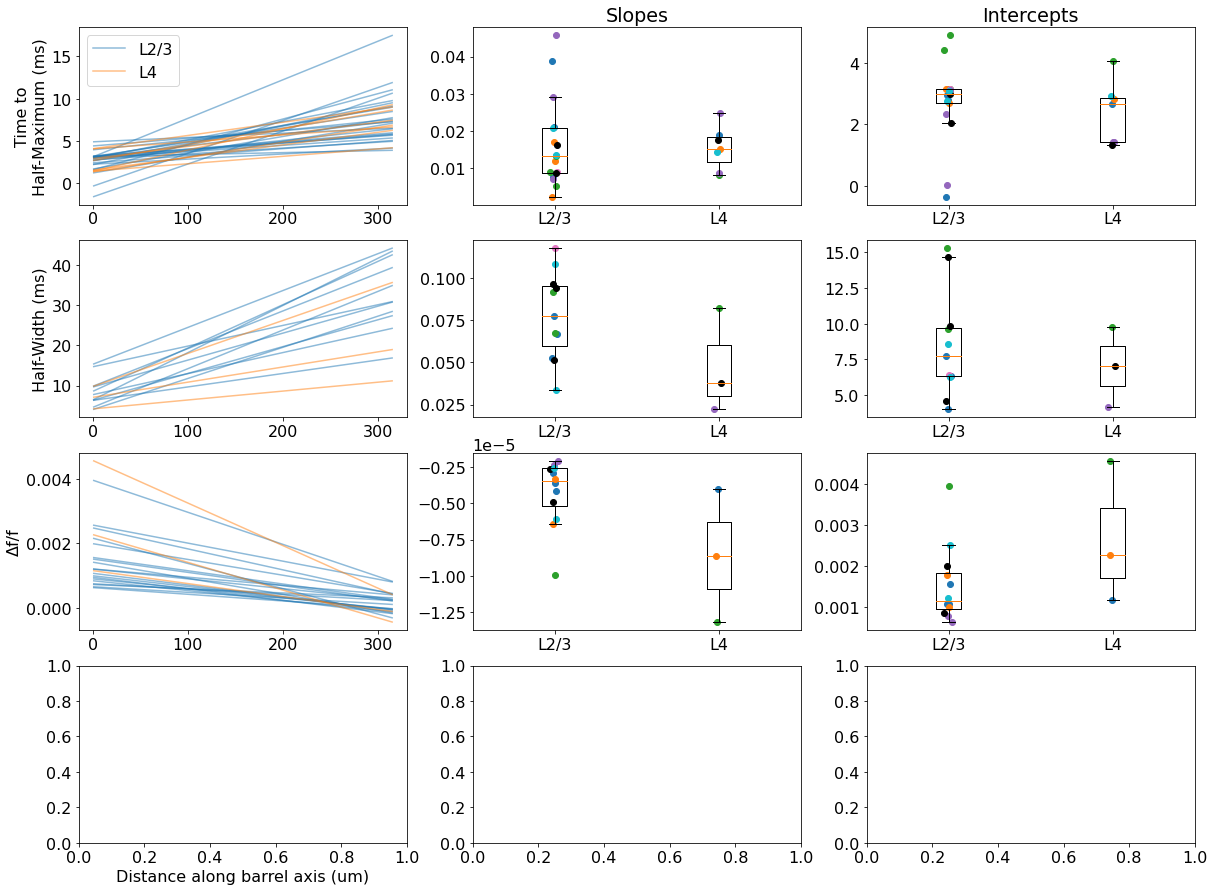

FDR-corrected p-values for slope and intercept of L2/3 vs L4 linear regressions: [0.82343816 0.59183754 0.59183754 0.59183754 0.59183754 0.59183754]


In [26]:
# plot linear regressions for neighbor barrel, L2/3 versus L4 (Stim_Location)
plt.rcParams.update({'font.size': 16})

predictor = 'Distance_Along_Barrel_Axis'
barrel = 'neighbor'

compare_column_name = 'Stim_Location' # 'Sex'  # 
compare_column_values = ['L2/3', 'L4'] # ['M', 'F']  # 

p_vals = []
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
for i_plotrow, response_type in enumerate(['Value_lat', 'Value_hw', 'Value']): # 'Max_Amp_Time', 
    
    df = merged_df[(merged_df['Value_hw'] > 0) & 
                   (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
    
    if barrel == 'neighbor':
        df = df[(df['Barrel'] != df['Home_Barrel'])]  # restrict to neighbor barrels
    elif barrel == 'home':
        df = df[(df['Barrel'] == df['Home_Barrel'])]

    df = df[df[response_type] > 0]  # remove any negative values
    linear_regressions = {'coronal': [], 'sagittal': []}
    lin_intercepts = {'coronal': [], 'sagittal': []}
    x_jitter_1 = np.random.normal(0, 0.01, 400)
    x_jitter_2 = np.random.normal(0, 0.01, 400) + 1
    handles = []
    i_jit = 0

    for i, stim_loc in enumerate(compare_column_values):
        df_stim_loc = df[df[compare_column_name] == stim_loc]

        # for each date
        for j, date in enumerate(df_stim_loc['Date'].unique()):
            df_date = df_stim_loc[df_stim_loc['Date'] == date]

            
            for jx, slic_id in enumerate(df_date['Slice'].unique()):
                df_slic = df_date[(df_date['Slice'] == slic_id)]

                # for each location, fit a linear regression
                slice_slopes = []
                slice_intercepts = []
                for jxx, loc_id in enumerate(df_slic['Loc'].unique()):
                    df_loc = df_slic[df_slic['Loc'] == loc_id]
                    if len(df_loc) < 3:
                        continue

                    # fit linear regression for latency and distance along barrel axis
                    slope, intercept, r_value, p_value, std_err = linregress(df_loc[predictor], df_loc[response_type])
                    if p_value < 0.025:
                        slice_slopes.append(slope)
                        slice_intercepts.append(intercept)
                        
                        x = np.linspace(min(df[predictor]), max(df[predictor]), 100)
                        y = slope * x + intercept
                        l1 = ax[i_plotrow][0].plot(x, y, alpha=0.5, c=("tab:blue" if stim_loc == compare_column_values[0] else "tab:orange"), 
                                                   label=stim_loc)
                        handles.append(l1[0])

                # plot the mean of the slopes and intercepts for each slice
                if len(slice_slopes) > 0:
                    if stim_loc == compare_column_values[0]:
                        linear_regressions['coronal'].append(np.mean(slice_slopes))
                        lin_intercepts['coronal'].append(np.mean(slice_intercepts))
                        ax[i_plotrow][1].scatter(x_jitter_1[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                        ax[i_plotrow][2].scatter(x_jitter_1[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                    elif stim_loc == compare_column_values[1]:
                        linear_regressions['sagittal'].append(np.mean(slice_slopes))
                        lin_intercepts['sagittal'].append(np.mean(slice_intercepts))
                        ax[i_plotrow][1].scatter(x_jitter_2[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                        ax[i_plotrow][2].scatter(x_jitter_2[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                    i_jit += 1

    # add boxplots
    ax[i_plotrow][1].boxplot([linear_regressions['coronal'], linear_regressions['sagittal']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
    ax[i_plotrow][2].boxplot([lin_intercepts['coronal'], lin_intercepts['sagittal']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)

    # print the mean and std of the slopes and intercepts for this response type
    print(response_type, "Mean slope L2/3:", np.mean(linear_regressions['coronal']), "std:", sem(linear_regressions['coronal']))
    print(response_type, "Mean slope L4:", np.mean(linear_regressions['sagittal']), "std:", sem(linear_regressions['sagittal']))
    print(response_type, "Mean intercept L2/3:", np.mean(lin_intercepts['coronal']), "std:", sem(lin_intercepts['coronal']))
    print(response_type, "Mean intercept L4:", np.mean(lin_intercepts['sagittal']), "std:", sem(lin_intercepts['sagittal']))

    # significance tests between coronal and sagittal (Welch's t-test)
    t_stat, p_val1 = ttest_ind(linear_regressions['coronal'], linear_regressions['sagittal'], alternative='two-sided', equal_var=False)
    print("p_val for slope L2/3 vs L4:", p_val1)
    t_stat, p_val2 = ttest_ind(lin_intercepts['coronal'], lin_intercepts['sagittal'], alternative='two-sided', equal_var=False)
    print("p_val for intercept L2/3 vs L4:", p_val2)

    p_vals.append(p_val1)
    p_vals.append(p_val2)

    # add significance lines
    '''if p_val1 < 0.05:
        ax[i_plotrow][1].plot([0, 1], [0.5, 0.5], color='black')
        ax[i_plotrow][1].annotate("p = " + str(round(p_val1, 2)), (0.4, 0.505), color='black', fontsize=12)
    if p_val2 < 0.05:
        ax[i_plotrow][2].plot([0, 1], [55, 55], color='black')
        ax[i_plotrow][2].annotate("p = " + str(round(p_val2, 2)), (0.4, 55.1), color='black', fontsize=12)'''
    
    if i_plotrow == 0:
        ax[i_plotrow][0].legend(handles=[handles[0], handles[-1]], labels=compare_column_values)
    for i in range(1,3):
        ax[i_plotrow][i].set_xticks([0, 1])
        ax[i_plotrow][i].set_xticklabels(compare_column_values)
        ax[i_plotrow][i].set_xlim(-0.5, 1.5)

    if predictor == 'Distance_Along_Barrel_Axis' or predictor == 'Distance':
        if response_type == 'Value_lat':            
            ax[i_plotrow][0].set_ylabel("Time to\nHalf-Maximum (ms)")
        elif response_type == 'Value_hw':
            ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
        elif response_type == 'Value':
            ax[i_plotrow][0].set_ylabel("Δf/f")
        elif response_type == 'Max_Amp_Time':
            ax[i_plotrow][0].set_ylabel("Time to Peak (ms)")

    elif predictor == 'Value_hw':
        if response_type == 'Value_lat':
            ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
            ax[i_plotrow][0].set_ylabel("Latency (ms)")

        elif response_type == 'Value_hw':
            ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
            ax[i_plotrow][0].set_ylabel("Half-Width (ms)")

'''# in the last row, plot the distributions of Neighbor_Responding_Area_Fraction comparing L2/3 and L4
# we only want one ROI per slice/loc (they are all the same) so filter to ROI == 1
df = merged_df[(merged_df['Value_hw'] > 0) & 
                   (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
df = df[df['ROI'] == 1]
df = df[df['Barrel'] != df['Home_Barrel']]
df = df[df['Value'] > 0]  # remove any negative values
df = df[df['Value_hw'] > 0]  # remove any negative values
for i, stim_loc in enumerate(['L2/3', 'L4']):
    df_stim_loc = df[df['Stim_Location'] == stim_loc]
    x_jitter = np.random.normal(0, 0.05, len(df_stim_loc)) + i
    ax[4][0].scatter(x_jitter, df_stim_loc['Neighbor_Responding_Area_Fraction'], label=stim_loc, c='tab:blue' if stim_loc == 'L2/3' else 'tab:orange', alpha=0.5)
    ax[4][0].set_xticks([0, 1])
    ax[4][0].set_xticklabels(["L2/3", "L4"])
    ax[4][0].set_ylabel("Neighbor Responding Area Fraction")
    ax[4][0].legend()

    print(df[df['Stim_Location'] == 'L2/3']['Neighbor_Responding_Area_Fraction'], 
                      df[df['Stim_Location'] == 'L4']['Neighbor_Responding_Area_Fraction'])

    # add boxplot
    ax[4][0].boxplot([df[df['Stim_Location'] == 'L2/3']['Neighbor_Responding_Area_Fraction'], 
                      df[df['Stim_Location'] == 'L4']['Neighbor_Responding_Area_Fraction']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
    t_stat, p_val = ttest_ind(df[df['Stim_Location'] == 'L2/3']['Neighbor_Responding_Area_Fraction'], 
                              df[df['Stim_Location'] == 'L4']['Neighbor_Responding_Area_Fraction'], alternative='two-sided', equal_var=False)
    print("p_val for L2/3 vs L4 Neighbor Responding Area Fraction:", p_val)
    if p_val < 0.05:
        ax[4][0].plot([0, 1], [0.1, 0.1], color='black')
        ax[4][0].annotate("p = " + str(round(p_val, 2)), (0.4, 0.105), color='black', fontsize=12)'''

ax[0][1].set_title("Slopes")
ax[0][2].set_title("Intercepts")
ax[3][0].set_xlabel("Distance along barrel axis (um)")
plt.savefig("P:/John/crossing-paper/input/output-" + compare_column_name + ".png")
plt.show()

p_vals = false_discovery_control(p_vals)
print("FDR-corrected p-values for slope and intercept of L2/3 vs L4 linear regressions:", p_vals)

Age list: [92.0, 92.0, 92.0, 93.0, 93.0, 93.0, 71.0, 71.0, 71.0, 72.0, 151.0, 151.0, 151.0, 151.0, 151.0, 53.0, 53.0, 53.0, 54.0, 54.0] [0.025254798206722027, 0.00957479121733991, 0.020377583174044974, 0.011844789094988425, 0.004724701852557222, 0.010983546716927119, 0.004789224399172834, 0.012270936323863474, 0.013287381506884896, 0.008932487925786306, 0.029123167295492774, 0.015266481712657815, 0.01967716961284585, 0.007230025839420196, 0.0352902469383299, 0.007137347427745736, 0.01556131245414764, 0.008128060434372595, 0.013987839036413267, 0.020776062824959803] [1.319386094046723, 3.235262424299788, 2.76394234117695, 2.7025675395786184, 3.5762652801222155, 2.9254823471816267, 4.403048599636824, 4.938674771411587, 3.147078491519647, 3.1500838027107028, 0.024956008833976195, 2.206407592756104, 0.6338259495917411, 2.326353356664023, 2.275219741395573, 3.3528040728996227, 2.1834610625056, 4.087395783383426, 2.9924762557252222, 2.7708607344395952]
Value_lat Mean slope: 0.014710897699733

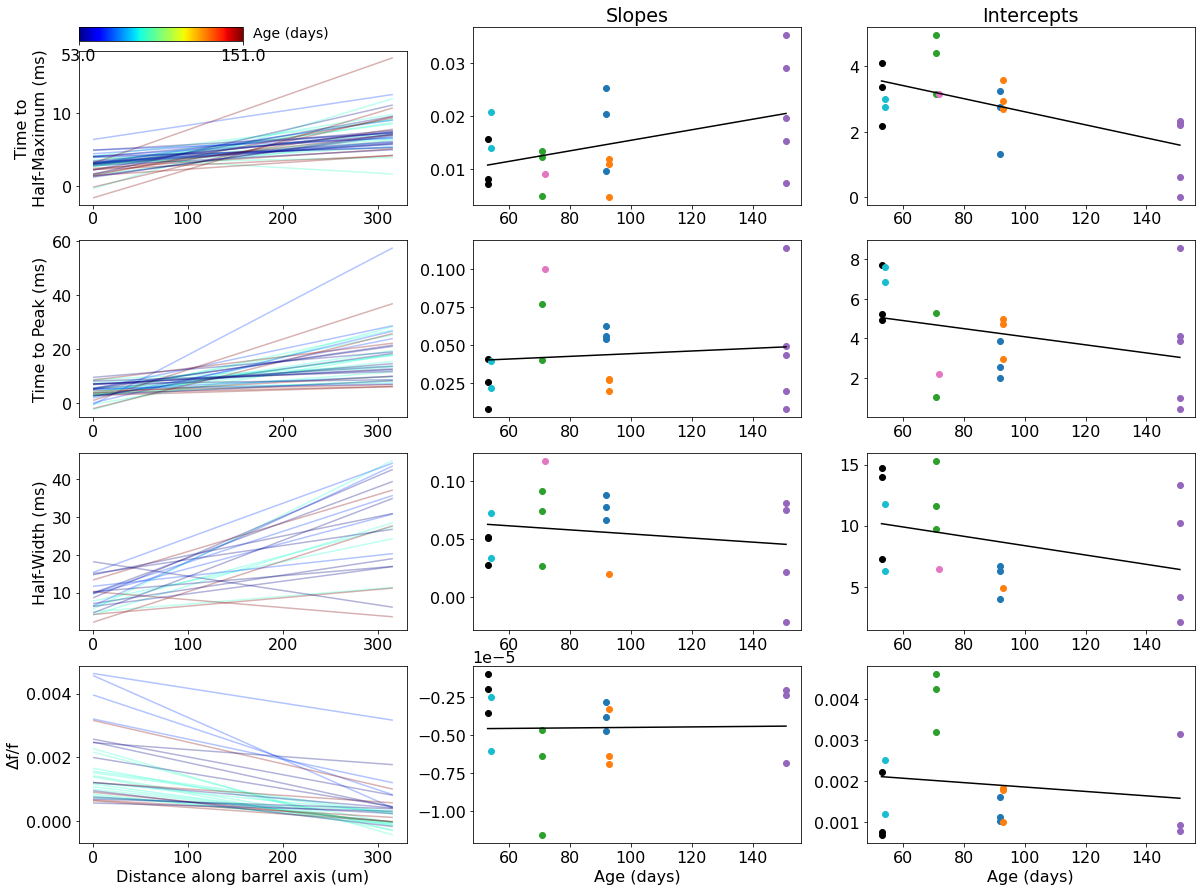

In [27]:
# plot Slope and intercept versus Age
plt.rcParams.update({'font.size': 16})

predictor = 'Distance_Along_Barrel_Axis'
barrel = 'neighbor'

p_vals = []
fig, ax = plt.subplots(4, 3, figsize=(20, 15))

for i_plotrow, response_type in enumerate(['Value_lat', 'Max_Amp_Time', 'Value_hw', 'Value']):
        
    df = merged_df[(merged_df['Value_hw'] > 0) & 
                (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
    
    if barrel == 'neighbor':
        df = df[(df['Barrel'] != df['Home_Barrel'])]  # restrict to neighbor barrels
    elif barrel == 'home':
        df = df[(df['Barrel'] == df['Home_Barrel'])]

    df = df[df[response_type] > 0]  # remove any negative values
    linear_regressions = []
    lin_intercepts = []
    age_list = []
    handles = []
    i_jit = 0

    for i, age in enumerate(df['Age'].unique()):
        df_age = df[df['Age'] == age]

        # for each date
        for j, date in enumerate(df_age['Date'].unique()):
            df_date = df_age[df_age['Date'] == date]

            
            for jx, slic_id in enumerate(df_date['Slice'].unique()):
                df_slic = df_date[(df_date['Slice'] == slic_id)]

                # for each location, fit a linear regression
                slice_slopes = []
                slice_intercepts = []
                for jxx, loc_id in enumerate(df_slic['Loc'].unique()):
                    df_loc = df_slic[df_slic['Loc'] == loc_id]
                    if len(df_loc) < 3:
                        continue

                    # fit linear regression for latency and distance along barrel axis
                    slope, intercept, r_value, p_value, std_err = linregress(df_loc[predictor], df_loc[response_type])
                    if p_value < 0.1:
                        slice_slopes.append(slope)
                        slice_intercepts.append(intercept)
                        
                        x = np.linspace(min(df[predictor]), max(df[predictor]), 100)
                        y = slope * x + intercept
                        cmap = plt.get_cmap('jet')
                        max_age = max(merged_df['Age'])
                        min_age = min(merged_df['Age'])
                        min_max_norm_age = (age - min_age) / (max_age - min_age)
                        ax[i_plotrow][0].plot(x, y, alpha=0.3, c=(cmap(min_max_norm_age)))

                # plot the mean of the slopes and intercepts for each slice
                if len(slice_slopes) > 0:
                    linear_regressions.append(np.mean(slice_slopes))
                    lin_intercepts.append(np.mean(slice_intercepts))
                    age_list.append(age)
                    ax[i_plotrow][1].scatter(age, np.mean(slice_slopes), c=color_by_date[date])
                    ax[i_plotrow][2].scatter(age, np.mean(slice_intercepts), c=color_by_date[date])

                    i_jit += 1

    print("Age list:", age_list, linear_regressions, lin_intercepts)
    # print the mean and std of the slopes and intercepts for this response type
    print(response_type, "Mean slope:", np.mean(linear_regressions), "std:", sem(linear_regressions))
    print(response_type, "Mean intercept:", np.mean(lin_intercepts), "std:", sem(lin_intercepts))

    # fit linear regression to slope vs age
    slope, intercept, r_value, p_value, std_err = linregress(age_list, linear_regressions)
    x = np.linspace(min(df['Age']), max(df['Age']), 100)
    y = slope * x + intercept
    ax[i_plotrow][1].plot(x, y, c='black')
    # annotate the p-value
    p_vals.append(p_value)

    # linear regression for intercept vs age
    slope, intercept, r_value, p_value, std_err = linregress(age_list, lin_intercepts)
    x = np.linspace(min(df['Age']), max(df['Age']), 100)
    y = slope * x + intercept
    ax[i_plotrow][2].plot(x, y, c='black')
    # annotate the p-value
    p_vals.append(p_value)

# add colormap legend
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin=min(df['Age']), vmax=max(df['Age']))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("top", size="13%", pad=0.05)

# make cax spines invisible
cax.spines['top'].set_visible(False)
cax.spines['right'].set_visible(False)
cax.spines['bottom'].set_visible(False)
cax.spines['left'].set_visible(False)
# make cax ticks invisible
cax.xaxis.set_ticks([])
cax.yaxis.set_ticks([])

cax.annotate("Age (days)", (0.53, 0.5), xycoords='axes fraction', fontsize=14)
iax = inset_axes(cax, width='50%', height='67%', loc='upper left', borderpad=0)

                        
cbar = plt.colorbar(sm, cax=iax, shrink=0.5, orientation='horizontal')
cbar.set_ticks([min(df['Age']), max(df['Age'])])
cbar.set_ticklabels([str(min(df['Age'])), str(max(df['Age']))])
iax.yaxis.tick_right()

ax[0, 1].set_title("Slopes")
ax[0, 2].set_title("Intercepts")
ax[3, 1].set_xlabel("Age (days)")
ax[3, 2].set_xlabel("Age (days)")
ax[3, 0].set_xlabel("Distance along barrel axis (um)")

# label response types e(['Value_lat', 'Max_Amp_Time', 'Value_hw', 'Value']):
ax[0][0].set_ylabel("Time to\nHalf-Maximum (ms)")
ax[2][0].set_ylabel("Half-Width (ms)")
ax[3][0].set_ylabel("Δf/f")
ax[1][0].set_ylabel("Time to Peak (ms)")

p_vals = false_discovery_control(p_vals)
print("FDR-corrected p-values for slope and intercept of linear regressions versus Age:", p_vals)
# annotate plots with p-values < 0.05
for i, p_val in enumerate(p_vals):
    if p_val < 0.01:
        print(i, i // 2, i % 2 + 1, p_val)
        i_plotrow = i // 2 # 2 p-values per response type
        i_plotcol = i % 2 + 1 # slope and intercept columns
        ax[0][2].annotate("p = " + str(round(p_val, 3)), (0.7, 0.45), color='black', fontsize=14, xycoords='axes fraction')
plt.savefig("P:/John/crossing-paper/input/output-age.png")
plt.show()


p_val for slope medial_caudal vs lateral_rostral: 0.12539402294321186
p_val for intercept medial_caudal vs lateral_rostral: 0.06276723426433801
p_val for slope medial_caudal vs lateral_rostral: 0.6268013996564554
p_val for intercept medial_caudal vs lateral_rostral: 0.1955112785552115
p_val for slope medial_caudal vs lateral_rostral: 0.3111103038724372
p_val for intercept medial_caudal vs lateral_rostral: 0.7033701126505676
p_val for slope medial_caudal vs lateral_rostral: 0.6498962647394743
p_val for intercept medial_caudal vs lateral_rostral: 0.5372791614452905


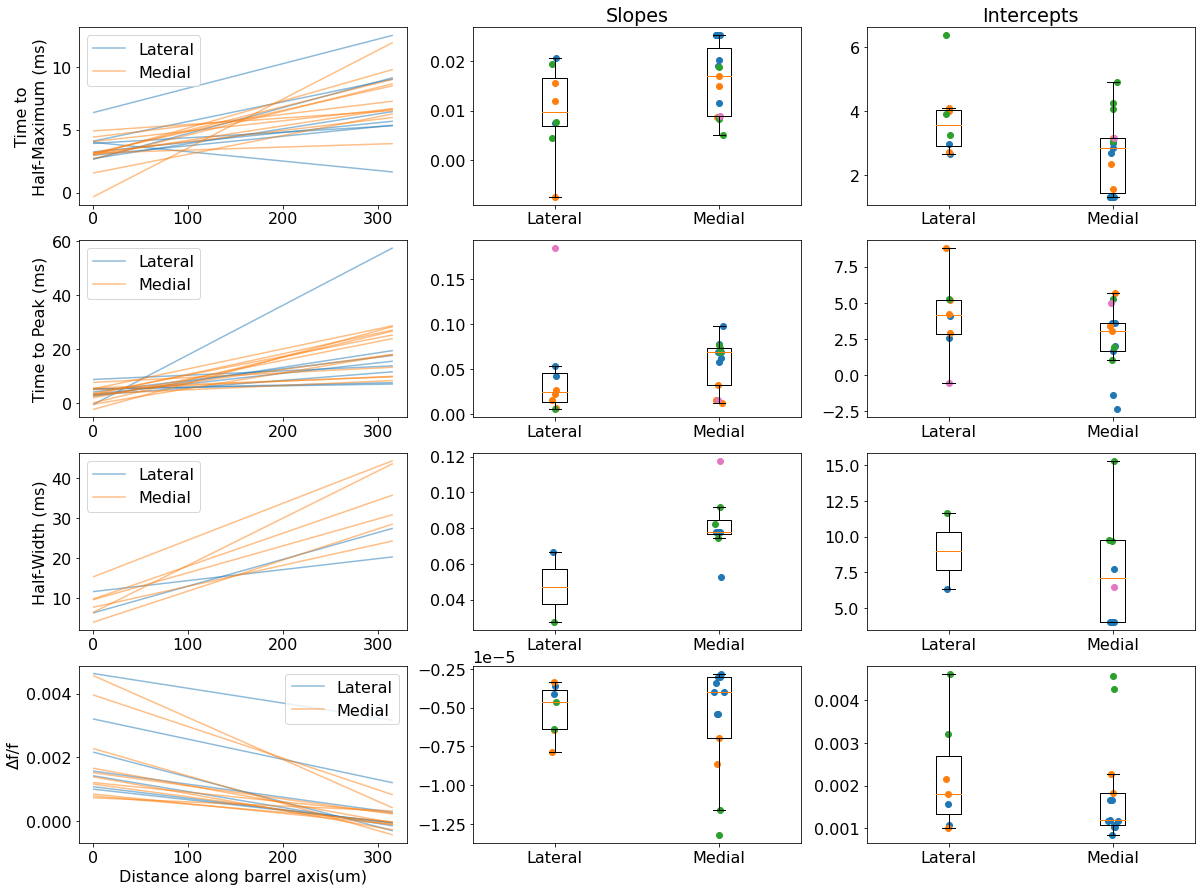

[0.12539402294321186, 0.06276723426433801, 0.6268013996564554, 0.1955112785552115, 0.3111103038724372, 0.7033701126505676, 0.6498962647394743, 0.5372791614452905]
FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions: [0.50157609 0.50157609 0.70337011 0.52136341 0.62222061 0.70337011
 0.70337011 0.70337011]
p_val for slope medial_caudal vs lateral_rostral: 0.3111769907221706
p_val for intercept medial_caudal vs lateral_rostral: 0.3134525330765046
p_val for slope medial_caudal vs lateral_rostral: 0.985966101037048
p_val for intercept medial_caudal vs lateral_rostral: 0.4088019387589553
p_val for slope medial_caudal vs lateral_rostral: 0.044682914618376174
p_val for intercept medial_caudal vs lateral_rostral: 0.21745572549052028
p_val for slope medial_caudal vs lateral_rostral: 0.8857822791669226
p_val for intercept medial_caudal vs lateral_rostral: 0.7408830631686634


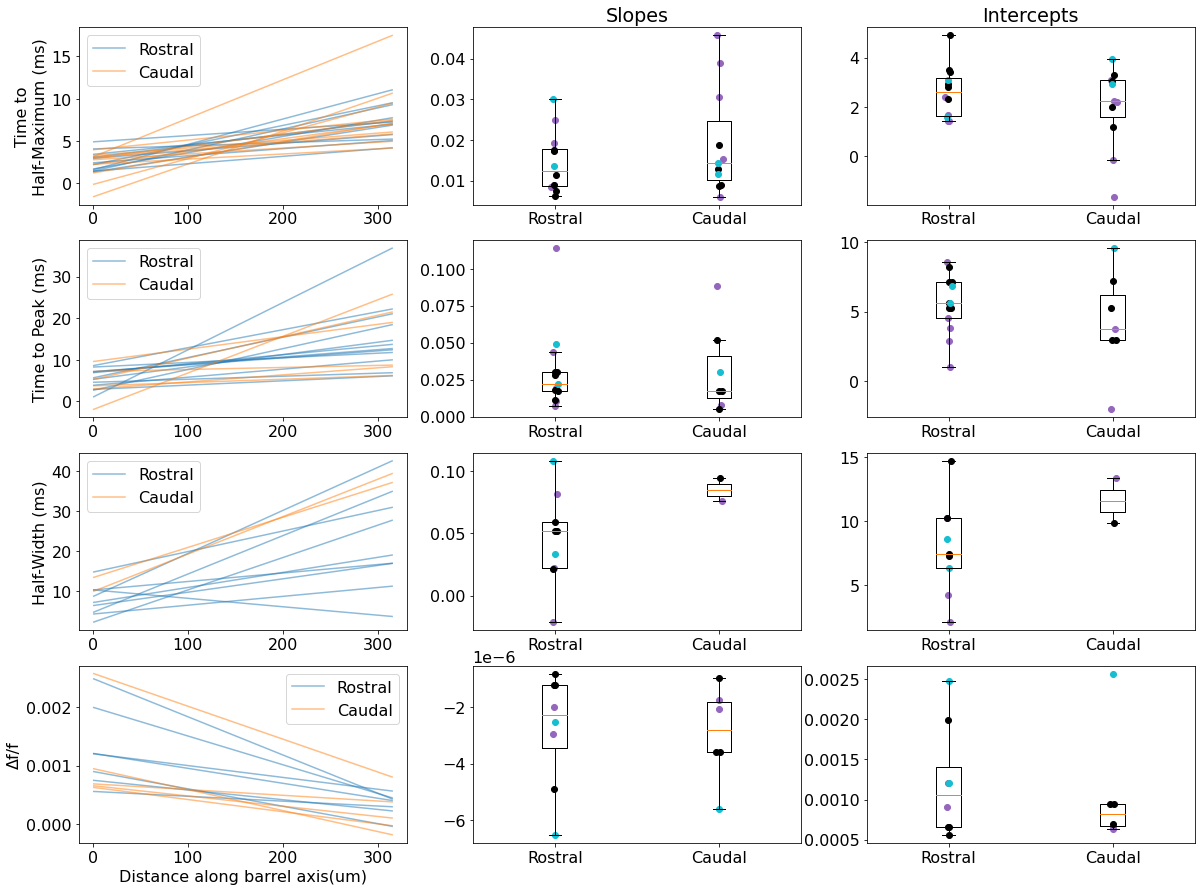

[0.3111769907221706, 0.3134525330765046, 0.985966101037048, 0.4088019387589553, 0.044682914618376174, 0.21745572549052028, 0.8857822791669226, 0.7408830631686634]
FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions: [0.62690507 0.62690507 0.9859661  0.6540831  0.35746332 0.62690507
 0.9859661  0.9859661 ]


In [28]:
# plot linear regressions for neighbor barrel, medial vs lateral
plt.rcParams.update({'font.size': 16})

for crossing_directions in [["Lateral", "Medial"], ["Rostral", "Caudal"]]:
    predictor = 'Distance_Along_Barrel_Axis'
    barrel = 'neighbor'
    p_vals = []

    fig, ax = plt.subplots(4, 3, figsize=(20, 15))

    for i_plotrow, response_type in enumerate(['Value_lat', 'Max_Amp_Time', 'Value_hw', 'Value']):
        df = merged_df[(merged_df['Value_hw'] > 0) & 
                    (merged_df['Value'] > 0.0001) & (merged_df[predictor] > 0)]
        
        if barrel == 'neighbor':
            df = df[(df['Barrel'] != df['Home_Barrel'])]  # restrict to neighbor barrels
        elif barrel == 'home':
            df = df[(df['Barrel'] == df['Home_Barrel'])]

        df = df[df[response_type] > 0]  # remove any negative values
        linear_regressions = {'medial_caudal': [], 'lateral_rostral': []}
        lin_intercepts = {'medial_caudal': [], 'lateral_rostral': []}
        x_jitter_1 = np.random.normal(0, 0.01, 400)
        x_jitter_2 = np.random.normal(0, 0.01, 400) + 1
        handles = []
        i_jit = 0
        for i, cross_dir in enumerate(crossing_directions):
            df_cd = df[df['Crossing_Direction'] == cross_dir]

            # for each date
            for j, date in enumerate(df_cd['Date'].unique()):
                df_date = df_cd[df_cd['Date'] == date]

                
                for jx, slic_id in enumerate(df_date['Slice'].unique()):
                    df_slic = df_date[(df_date['Slice'] == slic_id)]

                    # for each location, fit a linear regression
                    slice_slopes = []
                    slice_intercepts = []
                    for jxx, loc_id in enumerate(df_slic['Loc'].unique()):
                        df_loc = df_slic[df_slic['Loc'] == loc_id]

                        if len(df_loc) < 3:
                            continue

                        # fit linear regression for latency and distance along barrel axis
                        slope, intercept, r_value, p_value, std_err = linregress(df_loc[predictor], df_loc[response_type])
                        if p_value < 0.075:
                            slice_slopes.append(slope)
                            slice_intercepts.append(intercept)
                            
                            x = np.linspace(min(df[predictor]), max(df[predictor]), 100)
                            y = slope * x + intercept
                            l1 = ax[i_plotrow][0].plot(x, y, alpha=0.5, c=("tab:blue" if cross_dir == crossing_directions[0] else "tab:orange"), 
                                            label=cross_dir)
                            handles.append(l1[0])

                        # plot the mean of the slopes and intercepts for each slice
                        if len(slice_slopes) > 0:
                            if cross_dir == crossing_directions[0]:
                                linear_regressions['medial_caudal'].append(np.mean(slice_slopes))
                                lin_intercepts['medial_caudal'].append(np.mean(slice_intercepts))
                                ax[i_plotrow][1].scatter(x_jitter_1[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                                ax[i_plotrow][2].scatter(x_jitter_1[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                            else:
                                linear_regressions['lateral_rostral'].append(np.mean(slice_slopes))
                                lin_intercepts['lateral_rostral'].append(np.mean(slice_intercepts))
                                ax[i_plotrow][1].scatter(x_jitter_2[i_jit], np.mean(slice_slopes), c=color_by_date[date])
                                ax[i_plotrow][2].scatter(x_jitter_2[i_jit], np.mean(slice_intercepts), c=color_by_date[date])
                            i_jit += 1

        # add boxplots
        ax[i_plotrow][1].boxplot([linear_regressions['medial_caudal'], linear_regressions['lateral_rostral']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
        ax[i_plotrow][2].boxplot([lin_intercepts['medial_caudal'], lin_intercepts['lateral_rostral']], positions=[0, 1], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
        
        # significance tests between medial and lateral (Welch's t-test)
        t_stat, p_val1 = ttest_ind(linear_regressions['medial_caudal'], linear_regressions['lateral_rostral'], alternative='two-sided', equal_var=False)
        print("p_val for slope medial_caudal vs lateral_rostral:", p_val1)
        t_stat, p_val2 = ttest_ind(lin_intercepts['medial_caudal'], lin_intercepts['lateral_rostral'], alternative='two-sided', equal_var=False)
        print("p_val for intercept medial_caudal vs lateral_rostral:", p_val2)

        if p_val1 is not np.nan and 0 < p_val1 < 1:
            p_vals.append(p_val1)
        if p_val2 is not np.nan and 0 < p_val2 < 1:
            p_vals.append(p_val2)

        # add significance lines
        '''if p_val1 < 0.05:
            ax[1].plot([0, 1], [0.5, 0.5], color='black')
            ax[1].annotate("p = " + str(round(p_val1, 2)), (0.4, 0.505), color='black', fontsize=12)

        if p_val2 < 0.05:
            ax[2].plot([0, 1], [55, 55], color='black')
            ax[2].annotate("p = " + str(round(p_val2, 2)), (0.4, 55.1), color='black', fontsize=12)'''
        if len(handles) > 0:
            ax[i_plotrow][0].legend(handles=[handles[0], handles[-1]], labels=crossing_directions)
        for i in range(1,3):
            ax[i_plotrow][i].set_xticks([0, 1])
            ax[i_plotrow][i].set_xticklabels(crossing_directions)
            ax[i_plotrow][i].set_xlim(-0.5, 1.5)

        if predictor == 'Distance_Along_Barrel_Axis' or predictor == 'Distance':
            if response_type == 'Value_lat':
                            
                ax[i_plotrow][0].set_ylabel("Time to\nHalf-Maximum (ms)")

            elif response_type == 'Value_hw':
                ax[i_plotrow][0].set_ylabel("Half-Width (ms)")
            elif response_type == 'Value':
                ax[i_plotrow][0].set_ylabel("Δf/f")
            elif response_type == 'Max_Amp_Time':
                ax[i_plotrow][0].set_ylabel("Time to Peak (ms)")


        elif predictor == 'Value_hw':
            if response_type == 'Value_lat':
                ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
                ax[i_plotrow][0].set_ylabel("Latency (ms)")

            elif response_type == 'Value_hw':
                ax[i_plotrow][0].set_xlabel("Half-Width (ms)")
                ax[i_plotrow][0].set_ylabel("Half-Width (ms)")

        
    ax[3][0].set_xlabel("Distance along barrel axis(um)")
    ax[0][1].set_title("Slopes")
    ax[0][2].set_title("Intercepts")       
    plt.savefig("P:/John/crossing-paper/input/output-" + "-".join(crossing_directions) + ".png")
    plt.show()

    print(p_vals)
    p_vals = false_discovery_control(p_vals)
    print("FDR-corrected p-values for slope and intercept of coronal vs sagittal linear regressions:", p_vals)      


In [29]:
merged_df

,Date,Slice_Loc,ROI,Value,Value_hw,Max_Amp_Time,Value_lat,Distance,Distance_Along_Barrel_Axis,Barrel,...,Slice,Loc,Is_Home_Barrel,Is_Lateral_Crossing,Animal,Litter,Age,Sex,Is_Sagittal,Is_Rostral_Crossing
0,6/25/2024,3_1,1,0.000793,12.2953,4.900454,3.5026,170.762994,27.244597,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
1,6/25/2024,3_1,2,0.000645,17.7750,10.897859,3.4950,193.214906,55.578977,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
2,6/25/2024,3_1,3,0.000545,17.3931,6.399019,3.8332,231.758495,88.000047,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
3,6/25/2024,3_1,4,0.000469,17.1436,11.401010,4.1567,267.589237,119.603779,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
4,6/25/2024,3_1,5,0.000485,19.7282,12.896033,4.8331,278.919343,128.866942,1,...,3,1,0,0.0,6/25/2024,10,92.0,F,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,6/4/2024,4_2,3,0.001735,18.1069,9.399131,4.6176,258.278919,117.130321,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0
305,6/4/2024,4_2,4,0.001344,29.8651,11.400565,5.2690,282.255204,150.863854,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0
306,6/4/2024,4_2,5,0.001271,27.9799,13.398409,6.7454,308.110370,184.597387,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0
307,6/4/2024,4_2,6,0.001160,30.7221,15.900000,7.2281,323.610877,208.960493,2,...,4,2,0,NaN,6/4/2024,11,54.0,M,1,1.0


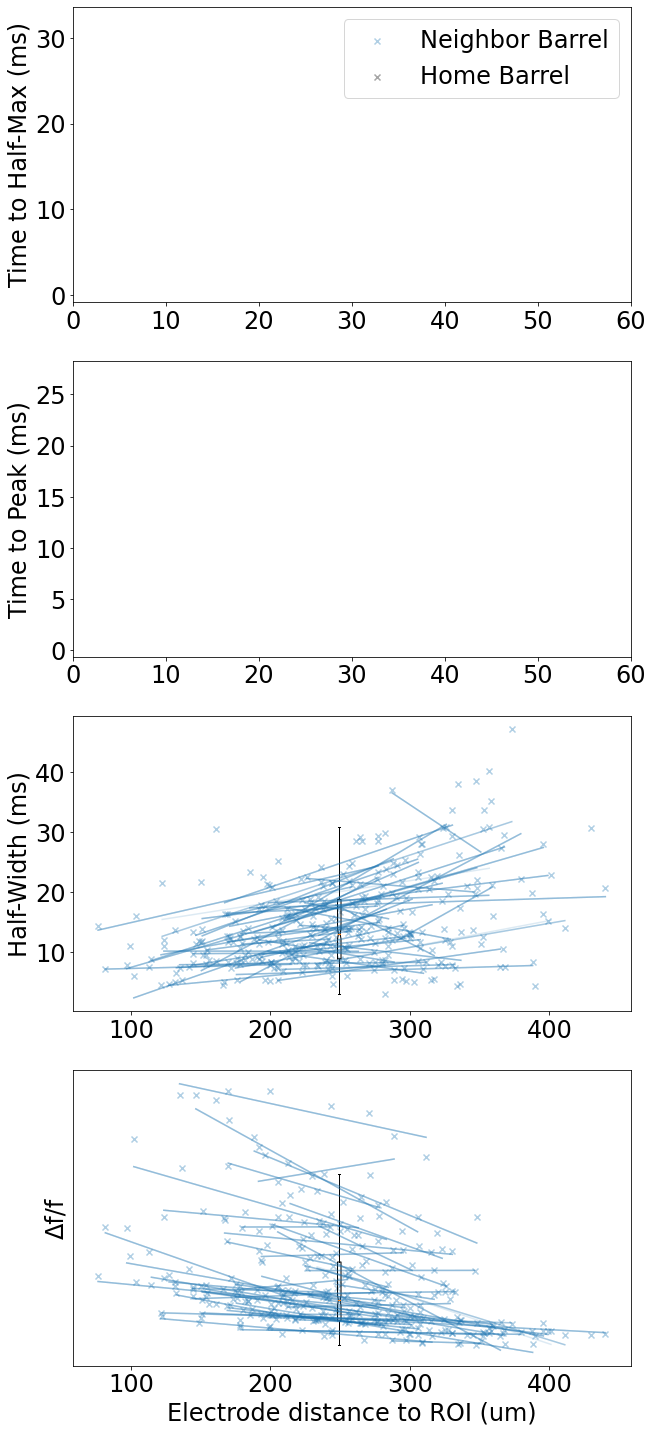

In [30]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff

# set matplotlib font size
plt.rcParams.update({'font.size': 24})
amp_cutoff = None
if amp_cutoff is not None:
    df_plot = merged_df[merged_df['Value'] > amp_cutoff]
else:
    df_plot = merged_df
for dist_type in ["Distance"]:
    handles = []
    fig, ax = plt.subplots(4, 1, figsize=(10, 25))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 0)]
    hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
    lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 0)]
    hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
    amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
    amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]
    max_amp_home = home_barrel_df[(home_barrel_df['Max_Amp_Time'] < 1000) & (home_barrel_df['Max_Amp_Time'] > 0)]
    max_amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Max_Amp_Time'] < 1000) & (neighbor_barrel_df['Max_Amp_Time'] > 0)]

    alph = 0.35
    l1 = ax[0].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                        label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[0], marker='x')
    l2 = ax[2].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                        label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[0], marker='x')
    l5 = ax[3].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                        label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[0], marker='x')
    l3 = ax[0].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                        label=direction + " Crossing Home Barrel", alpha=alph, c=colors[1], marker='x')
    l4 = ax[2].scatter(hw_home[dist_type], hw_home['Value_hw'],
                        label=direction + " Crossing Home Barrel", alpha=alph, c=colors[1], marker='x')
    l6 = ax[3].scatter(amp_home[dist_type], amp_home['Value'],
                        label=direction + " Crossing Home Barrel", alpha=alph, c=colors[1], marker='x')
    l7 = ax[1].scatter(max_amp_home[dist_type], max_amp_home['Max_Amp_Time'],
                        label=direction + " Crossing Home Barrel", alpha=alph, c=colors[1], marker='x')
    l8 = ax[1].scatter(max_amp_neighbor[dist_type], max_amp_neighbor['Max_Amp_Time'],
                        label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[0], marker='x')
    
    # plot box and whisker plots for each group
    ax[0].boxplot([lat_neighbor['Value_lat']], positions=[np.mean(lat_neighbor[dist_type])], 
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[2].boxplot([hw_neighbor['Value_hw']], positions=[np.mean(hw_neighbor[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[3].boxplot([amp_neighbor['Value']], positions=[np.mean(amp_neighbor[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[0].boxplot([lat_home['Value_lat']], positions=[np.mean(lat_home[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[2].boxplot([hw_home['Value_hw']], positions=[np.mean(hw_home[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[3].boxplot([amp_home['Value']], positions=[np.mean(amp_home[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[1].boxplot([max_amp_home['Max_Amp_Time']], positions=[np.mean(max_amp_home[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[1].boxplot([max_amp_neighbor['Max_Amp_Time']], positions=[np.mean(max_amp_neighbor[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    
    # plot a linear regression for each group
    for df_group in [lat_home, lat_neighbor, hw_home, hw_neighbor, amp_home, amp_neighbor, max_amp_home, max_amp_neighbor]:
        # for each date/slice/loc subset
        for date in df_group['Date'].unique():
            df_date = df_group[df_group['Date'] == date]
            for slic in df_date['Slice'].unique():
                df_slic = df_date[df_date['Slice'] == slic]
                for loc in df_slic['Loc'].unique():
                    df_loc = df_slic[df_slic['Loc'] == loc]
                    for is_home in df_loc['Is_Home_Barrel'].unique():
                        df_loc_is_home = df_loc[df_loc['Is_Home_Barrel'] == is_home]
                        i_plot = is_home
                        if len(df_loc_is_home) < 3:
                            continue
                        color = 'black' if is_home else 'tab:blue'
                        slope, intercept, r_value, p_value, std_err = linregress(df_loc_is_home[dist_type], df_loc_is_home['Value_lat'])
                        x = np.linspace(min(df_loc_is_home[dist_type]), max(df_loc_is_home[dist_type]), 100)
                        y = slope * x + intercept
                        ax[0].plot(x, y, c=color, alpha=0.15)
                        slope, intercept, r_value, p_value, std_err = linregress(df_loc_is_home[dist_type], df_loc_is_home['Value_hw'])
                        y = slope * x + intercept
                        ax[2].plot(x, y, c=color, alpha=0.15)
                        slope, intercept, r_value, p_value, std_err = linregress(df_loc_is_home[dist_type], df_loc_is_home['Value'])
                        y = slope * x + intercept
                        ax[3].plot(x, y, c=color, alpha=0.15)
                        slope, intercept, r_value, p_value, std_err = linregress(df_loc_is_home[dist_type], df_loc_is_home['Max_Amp_Time'])
                        y = slope * x + intercept
                        ax[1].plot(x, y, c=color, alpha=0.15)

    ax[0].set_ylabel("Time to Half-Max (ms)")
    ax[1].set_ylabel("Time to Peak (ms)")
    ax[2].set_ylabel("Half-Width (ms)")
    ax[3].set_ylabel("Δf/f")
    ax[3].set_yticks([])
    ax[0].legend(handles=[l1, l7], labels=["Neighbor Barrel", "Home Barrel"])
    
    for i in range(2):
        if dist_type == "Distance":
            ax[3].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[3].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):

        for j in range(2):
            if dist_type == "Distance":
                ax[j].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j].set_xlim(-40, 40)
        

    plt.show()

      Pt      ROI1      ROI2      ROI3      ROI4      ROI5
0      0  0.150516  0.170932  0.092306  0.120961  0.169601
1      1  0.052243  0.098903  0.061485  0.075389  0.082938
2      2 -0.019424  0.035880  0.036410  0.030774 -0.005488
3      3 -0.053597 -0.012905  0.007648 -0.014312 -0.088905
4      4 -0.056900 -0.042221 -0.026337 -0.052499 -0.148968
..   ...       ...       ...       ...       ...       ...
894  894 -0.000395 -0.026663 -0.076796 -0.024922 -0.010715
895  895 -0.017126 -0.052383 -0.080892 -0.085648 -0.045314
896  896 -0.009144 -0.063179 -0.078732 -0.146130 -0.099040
897  897  0.011003 -0.056961 -0.075472 -0.179886 -0.146411
898  898  0.028040 -0.043313 -0.072876 -0.185750 -0.175172

[899 rows x 6 columns]


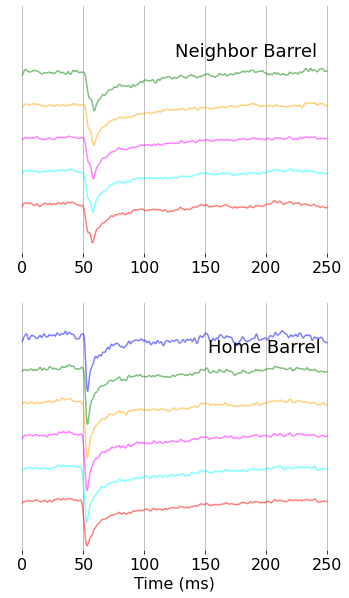

In [31]:
traces_neighbor = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-27-24/selected_zda/sample_traces_neighbor.dat'
traces_home = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing/06-27-24/selected_zda/sample_traces_home.dat'

# load traces
traces_neighbor = read_traces_file(traces_neighbor)
traces_home = read_traces_file(traces_home)
measure_window = [0, 500]
print(traces_neighbor)
# plot traces
plt.rcParams.update({'font.size': 16})

colors = ['red', 'cyan', 'magenta', 'orange', 'green', 'blue', 'black']
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
for i, traces in enumerate([traces_neighbor, traces_home]):
    headroom = 0
    for j, col_name in enumerate(traces.columns):
        if col_name == 'Pt':
            continue    
        traces = traces[measure_window[0]:measure_window[1]]
        ax[i].plot(traces['Pt'] * 0.5, -traces[col_name] + headroom, color=colors[(j-1) % len(colors)], alpha=0.5)
        headroom += 2
        ax[1].set_xlabel("Time (ms)")
        ax[i].set_yticks([])

ax[0].annotate("Neighbor Barrel", (0.5, 0.8), xycoords='axes fraction', fontsize=18, color='black')
ax[1].annotate("Home Barrel", (0.6, 0.8), xycoords='axes fraction', fontsize=18, color='black')

# add grid lines and set frame to not visible
for i in range(2):
    ax[i].grid(True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)

    ax[i].set_ylim(-3, 12)
    

plt.show()


## 